In [568]:
# Standard library
import warnings
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd
import pyreadstat

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing / feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer                                                      

# Modeling
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, calinski_harabasz_score, davies_bouldin_score

# Explaining
import shap

# 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Display
from IPython.display import display, HTML

#x
from sklearn.linear_model import BayesianRidge
from scipy import stats
import statsmodels.api as sm
import matplotlib.cm as cm

In [375]:
print("Current working directory:", Path.cwd())

Current working directory: c:\Users\gabri\Downloads\projekt 1


Settings / Configuration

In [376]:
warnings.filterwarnings("ignore")
seed=42
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

Function definitions

In [ ]:
def evaluate_regression_metrics_df(y_true, y_pred, warn=True):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    diffs = y_true - y_pred
    abs_diffs = np.abs(diffs)
    pct_diffs = abs_diffs / np.maximum(np.abs(y_true), 1e-8)
    pct_diff_squared = ((diffs / np.maximum(np.abs(y_true), 1e-8)) ** 2)

    if warn and np.any(np.abs(y_true) < 1e-6):
        print("Warning: `y_true` contains near-zero values - MAPE and RMSPE may be unstable.")

    mse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    metrics = {
        "MSE": mse,
        "RMSE": rmse,
        "RMSPE [%]": np.sqrt(np.mean(pct_diff_squared)) * 100,
        "MAE": mae,
        "MAPE [%]": np.mean(pct_diffs) * 100, 
        "R²": r2_score(y_true, y_pred),
        "Korelacja Pearsona": np.corrcoef(y_true, y_pred)[0, 1]
    }

    df = pd.DataFrame(list(metrics.items()), columns=["Metryka", "Wartość"])
    return df.round(4)

In [378]:
def plot_residuals(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    residuals = y_true - y_pred

    # Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=30, color='steelblue')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.title("Residuals Distribution")
    plt.xlabel("Residual")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [379]:
def plot_residuals_vs_fitted(model, X_test, y_true, title="Residuals vs Fitted"):
    y_pred = model.predict(X_test)
    residuals = y_true - y_pred
    
    plt.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel("Fitted values (Predicted satisfaction)")
    plt.ylabel("Residuals")
    plt.title(title)

Loading data

In [380]:
data_path = Path("data") / "bkl21d.sav"

if data_path.exists():
    survey_raw_df, meta = pyreadstat.read_sav(data_path)
else:
    print(f"Data file not found at {data_path}.")

In [381]:
survey_raw_df.head(5)

,id,intid,waga_proba,waga_proba_kor,waga_pop,waga_pop_kor,rodzaj,edycja,rok,datawyw,...,pform4t,neet,neet2,form12m,pform12m1,pform12m2,pform12m,nform12m,dokszt_all,dokszt_all_bo
0,6590.0,03540-2021,0.374529,0.379380,3732.470588,3780.814881,1.0,2021.0,2021.0,2021-09-20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,6591.0,02070-2021,0.865094,0.876299,8621.333333,8732.999924,1.0,2021.0,2021.0,2021-09-20,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,6592.0,01987-2021,0.283841,0.287518,2828.700000,2865.338333,1.0,2021.0,2021.0,2021-09-20,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
3,6593.0,01686-2021,1.380901,1.398787,13761.750000,13939.997104,1.0,2021.0,2021.0,2021-09-20,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
4,6594.0,04358-2021,0.897526,0.909151,8944.545455,9060.398404,1.0,2021.0,2021.0,2021-09-20,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [382]:
variables_info = pd.DataFrame({
    "Variable": meta.column_names,
    "Description": meta.column_labels
})

In [383]:
display(variables_info.head(20))

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łączonej
1,intid,ID wywiadu
2,waga_proba,Waga próby bez korekty przypadków ekstremalnych (skorygowana 2018)
3,waga_proba_kor,Waga próby z korektą przypadków ekstremalnych (skorygowana 2018)
4,waga_pop,Waga populacyjna bez korekty przypadków ekstremalnych (skorygowana 2018)
5,waga_pop_kor,Waga populacyjna z korektą przypadków ekstremalnych (skorygowana 2018)
6,rodzaj,Technika badania
7,edycja,Edycja badania
8,rok,BKL - rok badania
9,datawyw,Data wywiadu


In [384]:
columns_to_use = [
    "id", "wiek", "m1", "woj", "m2", "g8", "wykszt_7k", "p8", "e17", "u8",
    "n11", "j1_02", "j1_03", "j1_04", "j1_05", "j1_06", "j1_07", "j1_08",
    "j1_09", "j1_10", "j3_01", "j3_02", "j3_03", "j3_04", "j3_05", "j3_06",
    "j3_07", "j3_08", "j3_09", "j3_10", "j3_11", "j3_12", "j3_13", "m9_13k",
    "m9d", "m13", "o1_1", "o1_2", "o1_3", "j1_01"
]

Column selection

In [385]:
survey_selected_df = survey_raw_df[columns_to_use]

In [386]:
survey_selected_df.head(5)

,id,wiek,m1,woj,m2,g8,wykszt_7k,p8,e17,u8,...,j3_11,j3_12,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01
0,6590.0,59.0,1962.0,14.0,0.0,1.0,2.0,3.0,NaN,NaN,...,4.0,4.0,4.0,6.0,2500.0,3.0,5000.0,6000.0,-7.0,4.0
1,6591.0,19.0,2002.0,10.0,0.0,3.0,3.0,NaN,NaN,4.0,...,1.0,1.0,4.0,7.0,3000.0,5.0,2600.0,7500.0,14000.0,4.0
2,6592.0,37.0,1984.0,10.0,1.0,2.0,7.0,NaN,2.0,NaN,...,1.0,1.0,2.0,3.0,1100.0,4.0,2500.0,3000.0,4500.0,2.0
3,6593.0,25.0,1996.0,6.0,1.0,0.0,4.0,NaN,NaN,3.0,...,5.0,4.0,4.0,9.0,4000.0,2.0,5000.0,5000.0,10000.0,2.0
4,6594.0,24.0,1997.0,14.0,1.0,2.0,6.0,NaN,4.0,4.0,...,1.0,1.0,1.0,9.0,4800.0,5.0,6000.0,7500.0,10000.0,5.0


In [387]:
dictionary_df = pd.DataFrame({
    "Column": [c for c in meta.column_names if c in columns_to_use],
    "Description": [meta.column_labels[meta.column_names.index(c)] for c in meta.column_names if c in columns_to_use]
})

In [388]:
dictionary_df.head(10)

,Column,Description
0,id,Unikalny identyfikator respondenta w bazie łączonej
1,woj,Województwo (symbol terytorialny TERC)
2,m1,Rok urodzenia respondenta
3,wiek,Wiek
4,m2,Płeć respondenta
5,wykszt_7k,Wykształcenie ukończone (6 kat)
6,p8,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"
7,e17,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"
8,u8,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"
9,n11,"Na ile odpowiada praca, biorąc wszystko pod uwagę: samą pracę, jej warunki i zarobki"


In [389]:
dictionary_df.to_csv("data/data_dictionary.csv", index=False)

In [390]:
dictionary_df.head()

,Column,Description
0,id,Unikalny identyfikator respondenta w bazie łączonej
1,woj,Województwo (symbol terytorialny TERC)
2,m1,Rok urodzenia respondenta
3,wiek,Wiek
4,m2,Płeć respondenta


**Data cleaning**

Checking for bad values

In [391]:
#to delete
print(survey_selected_df['m9d'].describe())
print((survey_selected_df['m9d'] < 0).sum())

count     1220.000000
mean      4004.907377
std       2722.681496
min          2.000000
25%       2500.000000
50%       3300.000000
75%       4500.000000
max      30000.000000
Name: m9d, dtype: float64
0


Creating 'satisfaction' column

In [392]:
survey_selected_df.dtypes

id           float64
wiek         float64
m1           float64
woj          float64
m2           float64
g8           float64
wykszt_7k    float64
p8           float64
e17          float64
u8           float64
n11          float64
j1_02        float64
j1_03        float64
j1_04        float64
j1_05        float64
j1_06        float64
j1_07        float64
j1_08        float64
j1_09        float64
j1_10        float64
j3_01        float64
j3_02        float64
j3_03        float64
j3_04        float64
j3_05        float64
j3_06        float64
j3_07        float64
j3_08        float64
j3_09        float64
j3_10        float64
j3_11        float64
j3_12        float64
j3_13        float64
m9_13k       float64
m9d          float64
m13          float64
o1_1         float64
o1_2         float64
o1_3         float64
j1_01        float64
dtype: object

In [393]:
pd.set_option("display.max_colwidth", None)
print(variables_info[variables_info["Variable"].isin(survey_selected_df)])

      Variable  \
0           id   
11         woj   
19          m1   
20        wiek   
25          m2   
35   wykszt_7k   
69          p8   
208        e17   
282         u8   
321        n11   
366         g8   
372      j1_01   
373      j1_02   
374      j1_03   
375      j1_04   
376      j1_05   
377      j1_06   
378      j1_07   
379      j1_08   
380      j1_09   
381      j1_10   
385      j3_01   
386      j3_02   
387      j3_03   
388      j3_04   
389      j3_05   
390      j3_06   
391      j3_07   
392      j3_08   
393      j3_09   
394      j3_10   
395      j3_11   
396      j3_12   
397      j3_13   
486       o1_1   
487       o1_2   
488       o1_3   
822        m9d   
824     m9_13k   
833        m13   

                                                                                 Description  
0                                        Unikalny identyfikator respondenta w bazie łączonej  
11                                                    Województwo (symb

Filter for relevant types of employment (g8)

In [394]:
survey_selected_df["g8"].unique()

array([1., 3., 2., 0., 4., 5., 6.])

In [395]:
survey_selected_df = survey_selected_df[
    (survey_selected_df['g8'] > 1) & (survey_selected_df['g8'] < 5)
]

In [396]:
survey_selected_df.head(5)

,id,wiek,m1,woj,m2,g8,wykszt_7k,p8,e17,u8,...,j3_11,j3_12,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01
1,6591.0,19.0,2002.0,10.0,0.0,3.0,3.0,NaN,NaN,4.0,...,1.0,1.0,4.0,7.0,3000.0,5.0,2600.0,7500.0,14000.0,4.0
2,6592.0,37.0,1984.0,10.0,1.0,2.0,7.0,NaN,2.0,NaN,...,1.0,1.0,2.0,3.0,1100.0,4.0,2500.0,3000.0,4500.0,2.0
4,6594.0,24.0,1997.0,14.0,1.0,2.0,6.0,NaN,4.0,4.0,...,1.0,1.0,1.0,9.0,4800.0,5.0,6000.0,7500.0,10000.0,5.0
8,6598.0,49.0,1972.0,24.0,1.0,2.0,5.0,NaN,4.0,NaN,...,1.0,1.0,1.0,10.0,5000.0,4.0,3500.0,5500.0,6500.0,4.0
11,6601.0,46.0,1975.0,22.0,1.0,2.0,7.0,NaN,2.0,NaN,...,2.0,3.0,4.0,10.0,5000.0,NaN,-7.0,-7.0,-7.0,2.0


In [397]:
survey_selected_df["g8"].unique()

array([3., 2., 4.])

Initialize satisfaction column

In [398]:
satisfaction_columns = ['p8','e17','u8','n11']
survey_selected_df['satisfaction'] = np.nan

Assign satisfaction based on main employment type (g8)

In [399]:
g8_to_satisfaction_column = {1:'p8', 2:'e17', 3:'u8', 4:'n11'}

survey_selected_df['satisfaction'] = survey_selected_df.apply(
    lambda row: row[g8_to_satisfaction_column.get(row['g8'])] if row['g8'] in g8_to_satisfaction_column else None, axis=1
)

In [400]:
print(survey_selected_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 1 to 2527
Data columns (total 41 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1235 non-null   float64
 1   wiek          1235 non-null   float64
 2   m1            1235 non-null   float64
 3   woj           1235 non-null   float64
 4   m2            1235 non-null   float64
 5   g8            1235 non-null   float64
 6   wykszt_7k     1233 non-null   float64
 7   p8            27 non-null     float64
 8   e17           1130 non-null   float64
 9   u8            148 non-null    float64
 10  n11           51 non-null     float64
 11  j1_02         1138 non-null   float64
 12  j1_03         1221 non-null   float64
 13  j1_04         1216 non-null   float64
 14  j1_05         1218 non-null   float64
 15  j1_06         1205 non-null   float64
 16  j1_07         1219 non-null   float64
 17  j1_08         1214 non-null   float64
 18  j1_09         1225 non-null   flo

Remove respondents who did not provide a satisfaction rating

In [401]:
survey_selected_df = survey_selected_df.dropna(subset=['satisfaction'])

Drop original satisfaction columns (p8, e17, u8, n11)

In [402]:
survey_selected_df = survey_selected_df.drop(columns=satisfaction_columns)

In [403]:
survey_selected_df.head(5)

,id,wiek,m1,woj,m2,g8,wykszt_7k,j1_02,j1_03,j1_04,...,j3_12,j3_13,m9_13k,m9d,m13,o1_1,o1_2,o1_3,j1_01,satisfaction
1,6591.0,19.0,2002.0,10.0,0.0,3.0,3.0,4.0,5.0,5.0,...,1.0,4.0,7.0,3000.0,5.0,2600.0,7500.0,14000.0,4.0,4.0
2,6592.0,37.0,1984.0,10.0,1.0,2.0,7.0,2.0,3.0,4.0,...,1.0,2.0,3.0,1100.0,4.0,2500.0,3000.0,4500.0,2.0,2.0
4,6594.0,24.0,1997.0,14.0,1.0,2.0,6.0,5.0,5.0,5.0,...,1.0,1.0,9.0,4800.0,5.0,6000.0,7500.0,10000.0,5.0,4.0
8,6598.0,49.0,1972.0,24.0,1.0,2.0,5.0,3.0,5.0,5.0,...,1.0,1.0,10.0,5000.0,4.0,3500.0,5500.0,6500.0,4.0,4.0
11,6601.0,46.0,1975.0,22.0,1.0,2.0,7.0,3.0,5.0,5.0,...,3.0,4.0,10.0,5000.0,NaN,-7.0,-7.0,-7.0,2.0,2.0


Checking for missing values

In [404]:
print(survey_selected_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1202 entries, 1 to 2527
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1202 non-null   float64
 1   wiek          1202 non-null   float64
 2   m1            1202 non-null   float64
 3   woj           1202 non-null   float64
 4   m2            1202 non-null   float64
 5   g8            1202 non-null   float64
 6   wykszt_7k     1200 non-null   float64
 7   j1_02         1112 non-null   float64
 8   j1_03         1193 non-null   float64
 9   j1_04         1188 non-null   float64
 10  j1_05         1191 non-null   float64
 11  j1_06         1181 non-null   float64
 12  j1_07         1193 non-null   float64
 13  j1_08         1188 non-null   float64
 14  j1_09         1197 non-null   float64
 15  j1_10         1199 non-null   float64
 16  j3_01         1193 non-null   float64
 17  j3_02         1202 non-null   float64
 18  j3_03         1201 non-null   flo

In [405]:
missing_count = survey_selected_df.isnull().sum()
missing_percentage = (missing_count / len(survey_selected_df)) * 100

missing_report = pd.DataFrame({
    "variable": missing_count.index,
    "missing_count": missing_count.values,
    "missing_pct": missing_percentage.values
})

missing_report = missing_report[missing_report["missing_count"] > 0]
missing_report["description"] = missing_report["variable"].map(
    variables_info.set_index("Variable")["Description"]
)

missing_report = missing_report.sort_values("missing_pct", ascending=False)

print(missing_report)


     variable  missing_count  missing_pct  \
30        m9d            239    19.883527   
29     m9_13k            236    19.633943   
7       j1_02             90     7.487521   
31        m13             23     1.913478   
11      j1_06             21     1.747088   
13      j1_08             14     1.164725   
9       j1_04             14     1.164725   
21      j3_06             11     0.915141   
10      j1_05             11     0.915141   
8       j1_03              9     0.748752   
24      j3_09              9     0.748752   
16      j3_01              9     0.748752   
12      j1_07              9     0.748752   
22      j3_07              7     0.582363   
28      j3_13              7     0.582363   
20      j3_05              7     0.582363   
14      j1_09              5     0.415973   
25      j3_10              5     0.415973   
35      j1_01              5     0.415973   
23      j3_08              4     0.332779   
27      j3_12              3     0.249584   
15      j1

In [406]:
missing_cols = missing_report["variable"].tolist()  # reuse filtered list
missing_info = variables_info[variables_info["Variable"].isin(missing_cols)]

In [407]:
print(missing_info)

      Variable  \
35   wykszt_7k   
372      j1_01   
373      j1_02   
374      j1_03   
375      j1_04   
376      j1_05   
377      j1_06   
378      j1_07   
379      j1_08   
380      j1_09   
381      j1_10   
385      j3_01   
387      j3_03   
388      j3_04   
389      j3_05   
390      j3_06   
391      j3_07   
392      j3_08   
393      j3_09   
394      j3_10   
395      j3_11   
396      j3_12   
397      j3_13   
822        m9d   
824     m9_13k   
833        m13   

                                                                                 Description  
35                                                           Wykształcenie ukończone (6 kat)  
372                                                                     Zadowolenie: Zarobki  
373                                                           Zadowolenie: Możliwości awansu  
374                                                      Zadowolenie: Relacje z przełożonymi  
375                                   

Handling missing values

In [408]:
#Variable: wykszt_7k
#Original label (Polish): "Wykształcenie ukończone (6 kat)"
#Translated label (English): "Highest completed education (6 categories)"
survey_selected_df["wykszt_7k"] = survey_selected_df["wykszt_7k"].fillna(survey_selected_df["wykszt_7k"].mode()[0])

In [ ]:
#Variables j1_01 to j1_10: job satisfaction questions (1-5 scale)
#Topics include salary, promotion opportunities, relationships with supervisors, coworker interactions, job security, personal development, 
#work-life balance, initiative opportunities, work conditions, and overall job contentment.
j1_variables = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]  
print(j1_variables)  

['j1_01', 'j1_02', 'j1_03', 'j1_04', 'j1_05', 'j1_06', 'j1_07', 'j1_08', 'j1_09', 'j1_10']


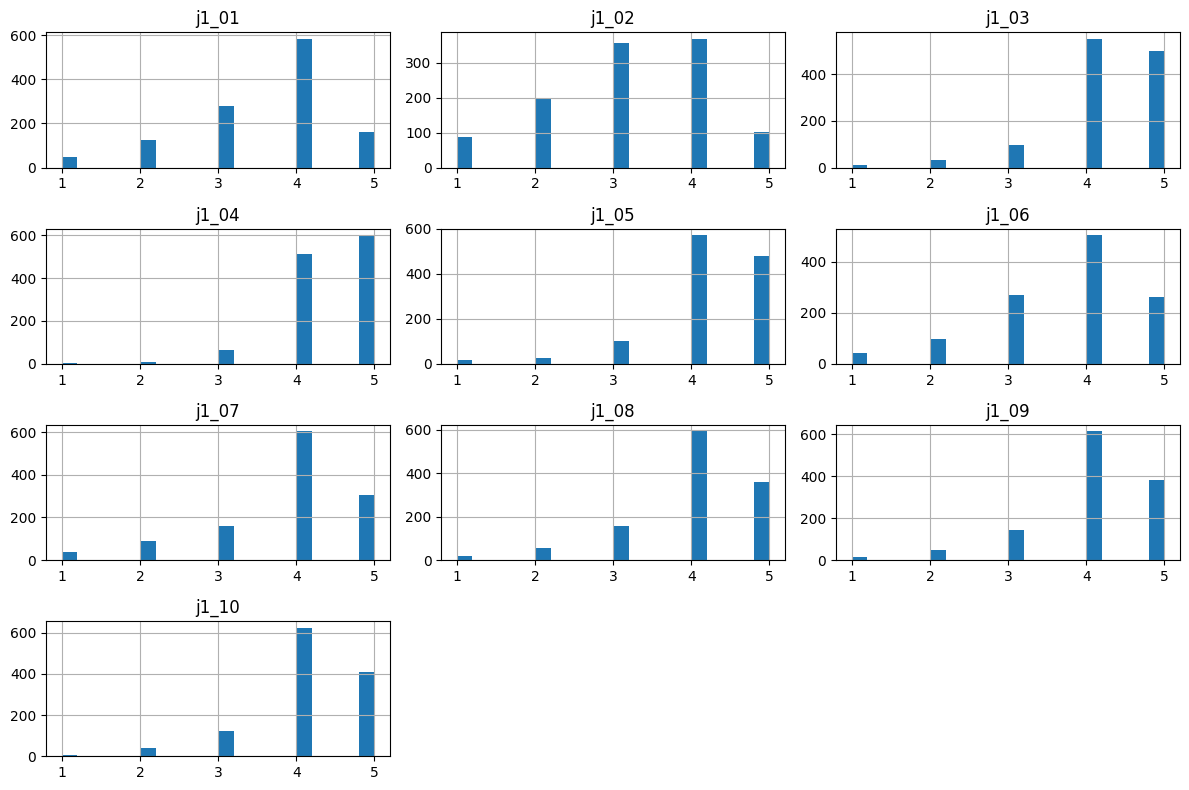

In [410]:
#Checking the skew of j1 variables
survey_selected_df[j1_variables].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [411]:
survey_selected_df[j1_variables].isna().sum()
survey_selected_df[j1_variables].isna().corr()

,j1_01,j1_02,j1_03,j1_04,j1_05,j1_06,j1_07,j1_08,j1_09,j1_10
j1_01,1.000000,0.178066,0.444220,0.113460,0.129533,0.188700,0.144331,0.113460,0.196658,0.255828
j1_02,0.178066,1.000000,0.231967,0.145887,0.105441,0.348090,0.085295,0.204811,0.079840,0.112474
j1_03,0.444220,0.231967,1.000000,0.440310,0.194347,0.283056,0.440253,0.260415,0.294276,0.189072
j1_04,0.113460,0.145887,0.440310,1.000000,0.233855,0.222257,0.350363,0.277297,0.233936,0.149974
j1_05,0.129533,0.105441,0.194347,0.233855,1.000000,0.120552,0.295694,0.396713,0.401020,0.345389
j1_06,0.188700,0.348090,0.283056,0.222257,0.120552,1.000000,0.283056,0.340623,0.287359,0.247854
j1_07,0.144331,0.085295,0.440253,0.350363,0.295694,0.283056,1.000000,0.440310,0.594165,0.382488
j1_08,0.113460,0.204811,0.260415,0.277297,0.396713,0.340623,0.440310,1.000000,0.474888,0.460782
j1_09,0.196658,0.079840,0.294276,0.233936,0.401020,0.287359,0.594165,0.474888,1.000000,0.514889
j1_10,0.255828,0.112474,0.189072,0.149974,0.345389,0.247854,0.382488,0.460782,0.514889,1.000000


In [ ]:
#Imputing missing values with median:
#Appropriate for ordinal Likert-scale variables (1-5) and robust to skew.
survey_selected_df[j1_variables] = survey_selected_df[j1_variables].fillna(survey_selected_df[j1_variables].median())

In [ ]:
#Variables j3_01 to j3_13: job-related statements (1-5 Likert scale)
#Respondents indicate agreement: 1 = strongly disagree, 5 = strongly agree
#Topics include work conditions, relationships, career development, and responsibilities
j3_variables = [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
print(j3_variables)

['j3_01', 'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06', 'j3_07', 'j3_08', 'j3_09', 'j3_10', 'j3_11', 'j3_12', 'j3_13']


<Axes: >

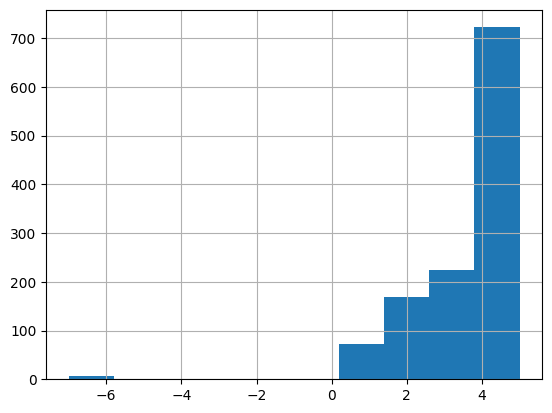

In [414]:
survey_selected_df['j3_01'].hist()

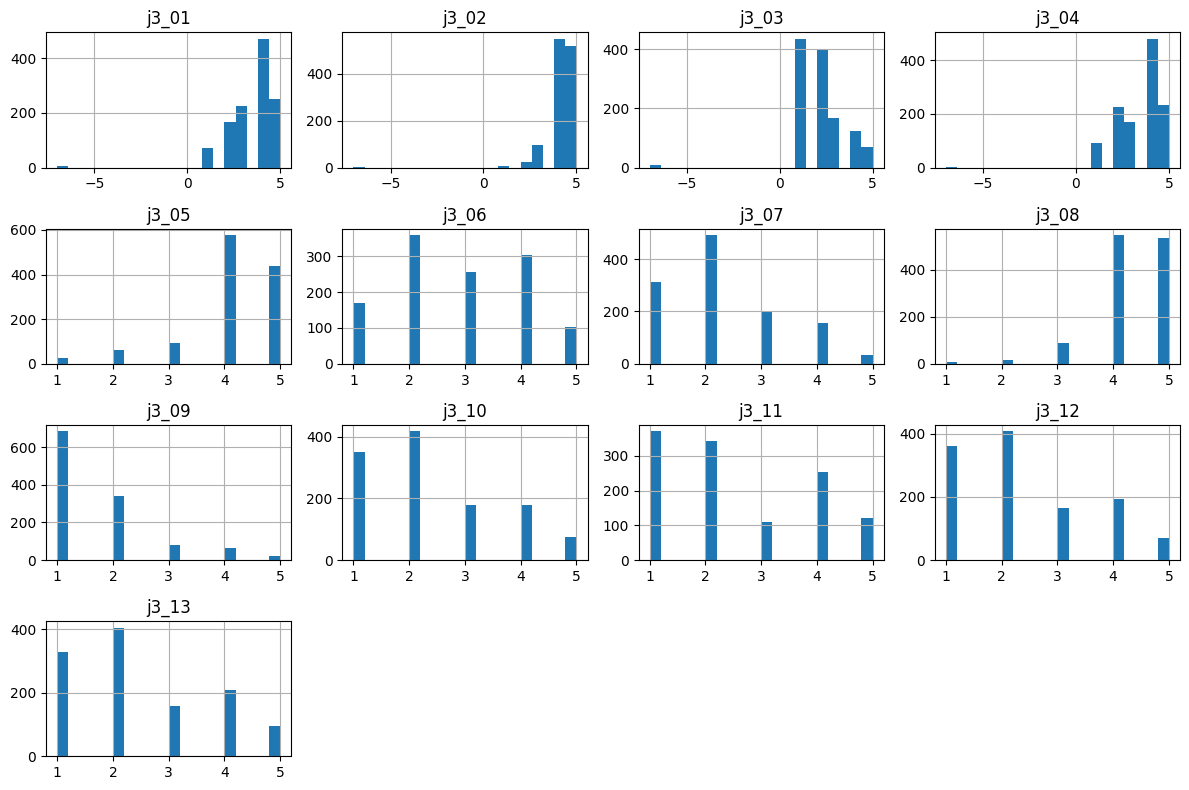

In [415]:
#Checking the skew of j3 variables
survey_selected_df[j3_variables].hist(bins=20, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [ ]:
#Checking value labels for j3_01-j3_04
#Purpose: confirm meaning of special codes (e.g., -5) before deciding how to treat them
for col in ["j3_01", "j3_02", "j3_03", "j3_04", "m13"]:
    label_set = meta.variable_value_labels.get(col)
    if label_set:
        print(f"{col}:", label_set)
    else:
        print(f"{col}: no value labels found")

j3_01: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
j3_02: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
j3_03: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
j3_04: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'zdecydowanie nie', 2.0: 'raczej nie', 3.0: 'ani tak ani nie', 4.0: 'raczej tak', 5.0: 'zdecydowanie tak'}
m13: {-8.0: 'trudno powiedzieć', -7.0: 'odmowa odpowiedzi', -3.0: 'brak danych', -1.0: 'NDT', 1.0: 'bardzo trudne', 2.0: 'trudne', 3.0: 'raczej trudne', 4.0: 'raczej ła

In [ ]:
#Recode special negative codes (-8, -7, -3, -1) to NaN in j3_01-j3_04
special_codes = [-8, -7, -3, -1, 8]
for col in ["j3_01", "j3_02", "j3_03", "j3_04", "m13"]:
    survey_selected_df[col] = survey_selected_df[col].replace(special_codes, np.nan)

In [418]:
survey_selected_df[j3_variables].isna().sum()
survey_selected_df[j3_variables].isna().corr()

,j3_01,j3_02,j3_03,j3_04,j3_05,j3_06,j3_07,j3_08,j3_09,j3_10,j3_11,j3_12,j3_13
j3_01,1.000000,0.444970,0.251040,0.417394,0.385364,0.225300,0.188380,0.123634,0.077171,0.109174,0.179288,0.294772,0.188380
j3_02,0.444970,1.000000,0.575904,0.706222,0.653561,0.520488,0.434431,0.286628,0.189072,0.255828,0.407057,0.331665,0.215301
j3_03,0.251040,0.575904,1.000000,0.541597,0.500682,0.295694,0.373849,0.162554,0.104405,0.144331,0.233241,0.189072,0.120185
j3_04,0.417394,0.706222,0.541597,1.000000,0.770291,0.365098,0.460006,0.200884,0.130785,0.178836,0.286748,0.233045,0.304864
j3_05,0.385364,0.653561,0.500682,0.770291,1.000000,0.566747,0.568918,0.375280,0.120185,0.334811,0.533408,0.215301,0.425224
j3_06,0.225300,0.520488,0.295694,0.365098,0.566747,1.000000,0.566747,0.449555,0.093000,0.265276,0.424799,0.170291,0.222286
j3_07,0.188380,0.434431,0.373849,0.460006,0.568918,0.566747,1.000000,0.185429,0.120185,0.334811,0.265142,0.215301,0.425224
j3_08,0.123634,0.286628,0.162554,0.200884,0.375280,0.449555,0.185429,1.000000,0.330128,0.445160,0.706517,0.286628,0.185429
j3_09,0.077171,0.189072,0.104405,0.130785,0.120185,0.093000,0.120185,0.330128,1.000000,0.594165,0.233241,0.189072,0.120185
j3_10,0.109174,0.255828,0.144331,0.178836,0.334811,0.265276,0.334811,0.445160,0.594165,1.000000,0.314513,0.255828,0.334811


In [ ]:
#Imputing missing values with median:
#Appropriate for ordinal Likert-scale variables (1-5) and robust to skew.
survey_selected_df[j3_variables] = survey_selected_df[j3_variables].fillna(survey_selected_df[j3_variables].median())

In [420]:
#Checking the remaining variables with missing values
salary_vars = [
    'm9d',
    'm9_13k'
    ]

In [421]:
pd.set_option("display.max_colwidth", None)
print(variables_info[variables_info["Variable"].isin(salary_vars)])

    Variable  \
822      m9d   
824   m9_13k   

                                                                              Description  
822  Przeciętne miesięczne zarobki netto w ost. 12m - dokładne (uwzgl. dane przedziałowe)  
824     Przeciętne miesięczne zarobki netto w ost. 12m - przedział (uwzgl. dane dokładne)  


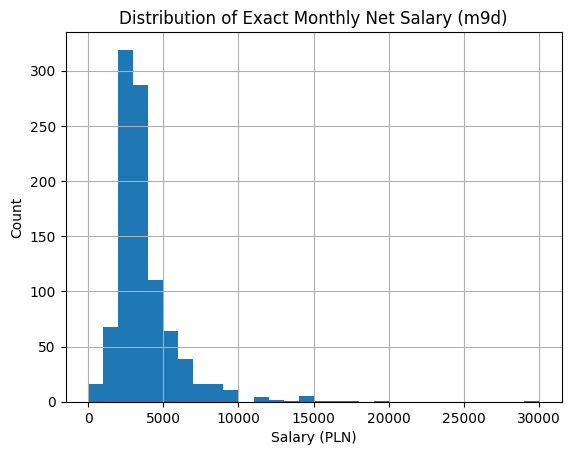

In [422]:
#Inspecting the distribution of monthly net salary (m9d)
survey_selected_df['m9d'].hist(bins=30)
plt.title("Distribution of Exact Monthly Net Salary (m9d)")
plt.xlabel("Salary (PLN)")
plt.ylabel("Count")
plt.show()

In [423]:
#Checking the descriptive stats for salary
survey_selected_df['m9d'].describe()

count      963.000000
mean      3917.322949
std       2348.428796
min          5.000000
25%       2600.000000
50%       3300.000000
75%       4500.000000
max      30000.000000
Name: m9d, dtype: float64

In [424]:
#Checking approximate bounds of the distribution
q_low = survey_selected_df['m9d'].quantile(0.01)   
q_high = survey_selected_df['m9d'].quantile(0.99)  
print(q_low, q_high)

555.8000000000001 14379.999999999996


In [425]:
#Removing all rows under minimum hourly rate for civil-law contracts (likely mis-coded entries)
#Retain high earners, since top values (30000pln) are plausible in general population
before = len(survey_selected_df)
survey_selected_df = survey_selected_df[
    (survey_selected_df['m9d'].isna()) | (survey_selected_df['m9d'] >= 30.5)
]
after = len(survey_selected_df)

print(f"Removed {before - after} rows with unrealistic salary values (<500 PLN).")

Removed 1 rows with unrealistic salary values (<500 PLN).


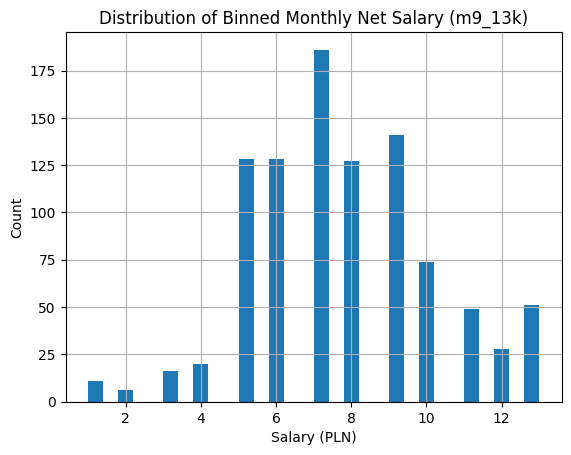

In [426]:
#Inspecting the distribution of monthly net salary (m9_13k)
survey_selected_df['m9_13k'].hist(bins=30)
plt.title("Distribution of Binned Monthly Net Salary (m9_13k)")
plt.xlabel("Salary (PLN)")
plt.ylabel("Count")
plt.show()

In [427]:
survey_selected_df['m9_13k'].isna().sum()

np.int64(236)

In [428]:
#overlap between two variables
missing_exact = survey_selected_df['m9d'].isnull()
missing_binned = survey_selected_df['m9_13k'].isnull()

#a count of missing values
total_missing_exact = missing_exact.sum()
total_missing_binned = missing_binned.sum()

In [429]:
overlap_mask = missing_exact & missing_binned
num_overlap = overlap_mask.sum()

In [430]:
print(num_overlap)
print(total_missing_binned)
print(total_missing_exact)

236
236
239


In [431]:
income_prediction_columns = [
    'wiek',
    'm2',
    'wykszt_7k',
    'j1_01',
    'j1_02',
    'j1_05',
    'j3_05',
    'satisfaction'
]

In [432]:
imputation_columns = ['m9d', 'm9_13k']

In [433]:
impute_df = survey_selected_df[imputation_columns].copy() #temporary imputation dataframe

In [434]:
print(survey_selected_df['m9d'].describe()) 
print((survey_selected_df['m9d'] < 0).sum())

count      962.000000
mean      3921.389813
std       2346.255048
min         37.000000
25%       2600.000000
50%       3350.000000
75%       4500.000000
max      30000.000000
Name: m9d, dtype: float64
0


In [435]:
imputer = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=15,
    random_state=42,
    min_value=30.5, #minimum hourly wage in Poland
    max_value=None
)

In [436]:
df_imputed_temp = pd.DataFrame( #temporary imputation dataframe
    imputer.fit_transform(impute_df),  
    columns=impute_df.columns,
    index=impute_df.index
    )

In [437]:
survey_selected_df['m9d'] = df_imputed_temp['m9d']
survey_selected_df['m9_13k'] = df_imputed_temp['m9_13k']

In [438]:
print("Missing values after imputation:")
print(survey_selected_df[['m9d', 'm9_13k']].isnull().sum())

Missing values after imputation:
m9d       0
m9_13k    0
dtype: int64


In [439]:
print(survey_selected_df['m9d'].describe()) 
print((survey_selected_df['m9d'] < 0).sum())

count     1201.000000
mean      7544.574925
std       7650.378375
min         30.500000
25%       2800.000000
50%       3750.000000
75%       7000.000000
max      30000.000000
Name: m9d, dtype: float64
0


In [440]:
m13_prediction_columns = [
    'm13',
    'm9d',     
    'j1_01',   
    'j1_05',   
    'j1_07',   
    'j3_05',    
    'satisfaction'
]

In [441]:
impute_df = survey_selected_df[m13_prediction_columns].copy()

In [442]:
df_imputed_temp = pd.DataFrame(
    imputer.fit_transform(impute_df), 
    columns=impute_df.columns,
    index=impute_df.index
    )

In [443]:
survey_selected_df['m13'] = df_imputed_temp['m13']

In [444]:
print("Missing values after imputation:")
print(survey_selected_df[['m13']].isnull().sum())

Missing values after imputation:
m13    0
dtype: int64


Inverting negatively worded items

In [445]:
survey_labels = variables_info[variables_info["Variable"].isin(survey_selected_df.columns)]
survey_labels

,Variable,Description
0,id,Unikalny identyfikator respondenta w bazie łączonej
11,woj,Województwo (symbol terytorialny TERC)
19,m1,Rok urodzenia respondenta
20,wiek,Wiek
25,m2,Płeć respondenta
35,wykszt_7k,Wykształcenie ukończone (6 kat)
366,g8,Główna praca
372,j1_01,Zadowolenie: Zarobki
373,j1_02,Zadowolenie: Możliwości awansu
374,j1_03,Zadowolenie: Relacje z przełożonymi


In [446]:
negative_items = ["j3_03", "j3_06", "j3_07", "j3_09", "j3_10", "j3_11", "j3_12", "j3_13"]

In [447]:
survey_selected_df[negative_items].head()

,j3_03,j3_06,j3_07,j3_09,j3_10,j3_11,j3_12,j3_13
1,2.0,4.0,1.0,1.0,1.0,1.0,1.0,4.0
2,4.0,3.0,2.0,2.0,4.0,1.0,1.0,2.0
4,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
8,1.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0
11,1.0,2.0,1.0,1.0,4.0,2.0,3.0,4.0


In [448]:
min_val = 1
max_val = 5

survey_selected_df[negative_items] = survey_selected_df[negative_items].apply(lambda x: (max_val + min_val) - x)

In [449]:
survey_selected_df[negative_items].head()

,j3_03,j3_06,j3_07,j3_09,j3_10,j3_11,j3_12,j3_13
1,4.0,2.0,5.0,5.0,5.0,5.0,5.0,2.0
2,2.0,3.0,4.0,4.0,2.0,5.0,5.0,4.0
4,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0
8,5.0,3.0,4.0,5.0,4.0,5.0,5.0,5.0
11,5.0,4.0,5.0,5.0,2.0,4.0,3.0,2.0


**Feature engineering**

In [450]:
def assign_generation(year):
    if 1946 <= year <= 1964:
        return 'BB'
    elif 1965 <= year <= 1980:
        return 'X'
    elif 1981 <= year <= 1994:
        return 'M'
    elif 1995 <= year <= 2010:
        return 'Z'
    elif year >= 2011:
        return 'A'
    else:
        return np.nan 

In [451]:
survey_selected_df['generation'] = survey_selected_df['m1'].apply(assign_generation)

In [452]:
survey_selected_df['generation'].isna().sum()

np.int64(0)

In [453]:
survey_selected_df.isna().sum()

id              0
wiek            0
m1              0
woj             0
m2              0
g8              0
wykszt_7k       0
j1_02           0
j1_03           0
j1_04           0
j1_05           0
j1_06           0
j1_07           0
j1_08           0
j1_09           0
j1_10           0
j3_01           0
j3_02           0
j3_03           0
j3_04           0
j3_05           0
j3_06           0
j3_07           0
j3_08           0
j3_09           0
j3_10           0
j3_11           0
j3_12           0
j3_13           0
m9_13k          0
m9d             0
m13             0
o1_1            0
o1_2            0
o1_3            0
j1_01           0
satisfaction    0
generation      0
dtype: int64

**Data types**

In [454]:
is_integer_m13 = (survey_selected_df['j1_01'] % 1 == 0).all()
print(f"Column 'm13' contains only integers: {is_integer_m13}")

Column 'm13' contains only integers: True


In [455]:
numeric_df = survey_selected_df.select_dtypes(include="number")
integer_check = numeric_df.apply(lambda col: (col % 1 == 0).all())
print(integer_check)

id               True
wiek             True
m1               True
woj              True
m2               True
g8               True
wykszt_7k        True
j1_02            True
j1_03            True
j1_04            True
j1_05            True
j1_06            True
j1_07            True
j1_08            True
j1_09            True
j1_10            True
j3_01            True
j3_02            True
j3_03            True
j3_04            True
j3_05            True
j3_06            True
j3_07            True
j3_08            True
j3_09            True
j3_10            True
j3_11            True
j3_12            True
j3_13            True
m9_13k          False
m9d             False
m13             False
o1_1             True
o1_2             True
o1_3             True
j1_01            True
satisfaction     True
dtype: bool


In [456]:
integer_columns = integer_check[integer_check].index.tolist()
print("Columns containing only integers:", integer_columns)

Columns containing only integers: ['id', 'wiek', 'm1', 'woj', 'm2', 'g8', 'wykszt_7k', 'j1_02', 'j1_03', 'j1_04', 'j1_05', 'j1_06', 'j1_07', 'j1_08', 'j1_09', 'j1_10', 'j3_01', 'j3_02', 'j3_03', 'j3_04', 'j3_05', 'j3_06', 'j3_07', 'j3_08', 'j3_09', 'j3_10', 'j3_11', 'j3_12', 'j3_13', 'o1_1', 'o1_2', 'o1_3', 'j1_01', 'satisfaction']


In [457]:
survey_selected_df[integer_columns] = survey_selected_df[integer_columns].astype("int64")

In [458]:
survey_selected_df.dtypes

id                int64
wiek              int64
m1                int64
woj               int64
m2                int64
g8                int64
wykszt_7k         int64
j1_02             int64
j1_03             int64
j1_04             int64
j1_05             int64
j1_06             int64
j1_07             int64
j1_08             int64
j1_09             int64
j1_10             int64
j3_01             int64
j3_02             int64
j3_03             int64
j3_04             int64
j3_05             int64
j3_06             int64
j3_07             int64
j3_08             int64
j3_09             int64
j3_10             int64
j3_11             int64
j3_12             int64
j3_13             int64
m9_13k          float64
m9d             float64
m13             float64
o1_1              int64
o1_2              int64
o1_3              int64
j1_01             int64
satisfaction      int64
generation       object
dtype: object

**Defining predictors and target**

In [459]:
likert_predictors = [f"j1_{str(i).zfill(2)}" for i in range(1, 11)]
likert_predictors += [f"j3_{str(i).zfill(2)}" for i in range(1, 14)]
likert_predictors += ["m13"]  

salary_predictor = ["m9d"]

In [460]:
y = survey_selected_df['satisfaction']

In [461]:
X_likert = survey_selected_df[likert_predictors]
X_all = survey_selected_df[likert_predictors + salary_predictor]

In [462]:
X_train_likert, X_test_likert, y_train, y_test = train_test_split(X_likert, y, test_size=0.2, random_state=42)

In [463]:
X_train_all, X_test_all, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

In [464]:
print(survey_selected_df['m9d'].describe()) 
print((survey_selected_df['m9d'] < 0).sum())

count     1201.000000
mean      7544.574925
std       7650.378375
min         30.500000
25%       2800.000000
50%       3750.000000
75%       7000.000000
max      30000.000000
Name: m9d, dtype: float64
0


**Scaling and data preprocessing**

In [465]:
salary_pipeline = Pipeline([
    ('log', FunctionTransformer(np.log1p, validate=False)), 
    ('scale', StandardScaler())
])

In [466]:
preprocessor_likert = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
    ])

In [467]:
preprocessor_all = ColumnTransformer(
    transformers=[
        ('likert_scaler', StandardScaler(), likert_predictors),
        ('salary_scaler', salary_pipeline, salary_predictor)
    ])

In [468]:
X_train_l_scaled = preprocessor_likert.fit_transform(X_train_likert)
X_train_a_scaled = preprocessor_all.fit_transform(X_train_all)
X_test_l_scaled = preprocessor_likert.transform(X_test_likert)
X_test_a_scaled = preprocessor_all.transform(X_test_all)

In [469]:
print("Mean of each scaled column:", np.mean(X_train_l_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_l_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [470]:
print("Mean of each scaled column:", np.mean(X_train_a_scaled, axis=0).round(2))
print("Standard deviation of each scaled column:", np.std(X_train_a_scaled, axis=0).round(2))

Mean of each scaled column: [ 0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.
 -0. -0.  0. -0.  0.  0.  0.]
Standard deviation of each scaled column: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


**Building models**

Linear Regression

In [471]:
model_reg_l = LinearRegression()
model_reg_l.fit(X_train_l_scaled, y_train)
y_pred_reg_l = model_reg_l.predict(X_test_l_scaled)

In [472]:
evaluate_regression_metrics_df(y_test, y_pred_reg_l)

,Metryka,Wartość
0,MSE,0.5631
1,RMSE,0.7504
2,RMSPE [%],33.6404
3,MAE,0.4378
4,MAPE [%],16.6890
5,R²,0.3151
6,Korelacja Pearsona,0.5616


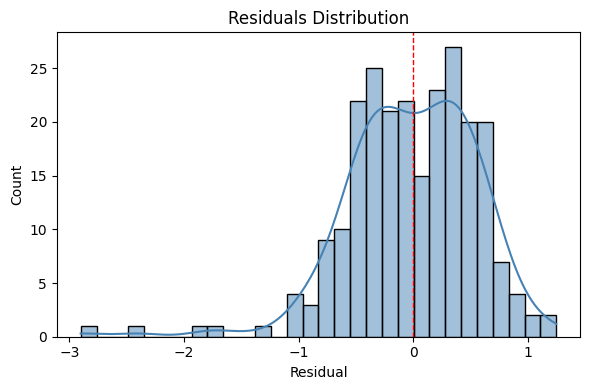

In [473]:
plot_residuals(y_test, y_pred_reg_l)

In [474]:
model_reg_a = LinearRegression()
model_reg_a.fit(X_train_a_scaled, y_train)
y_pred_reg_a = model_reg_a.predict(X_test_a_scaled)

In [475]:
evaluate_regression_metrics_df(y_test, y_pred_reg_a)

,Metryka,Wartość
0,MSE,0.5628
1,RMSE,0.7502
2,RMSPE [%],33.6942
3,MAE,0.4373
4,MAPE [%],16.7000
5,R²,0.3157
6,Korelacja Pearsona,0.5622


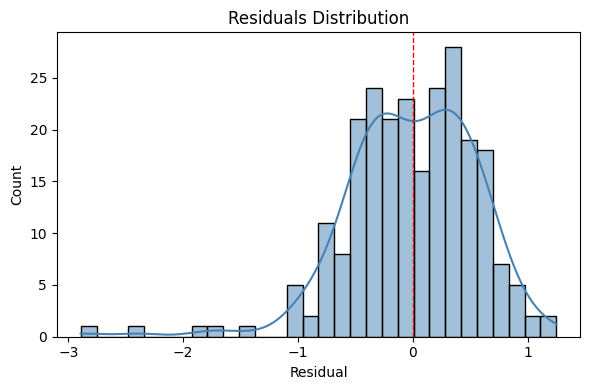

In [476]:
plot_residuals(y_test, y_pred_reg_a)

Random Forest Regressor

In [477]:
model_rf_l = RandomForestRegressor(random_state=42)
model_rf_l.fit(X_train_l_scaled, y_train)
y_pred_rf_l = model_rf_l.predict(X_test_l_scaled)

In [478]:
evaluate_regression_metrics_df(y_test, y_pred_rf_l)

,Metryka,Wartość
0,MSE,0.5905
1,RMSE,0.7684
2,RMSPE [%],35.1497
3,MAE,0.4529
4,MAPE [%],17.2954
5,R²,0.2468
6,Korelacja Pearsona,0.5024


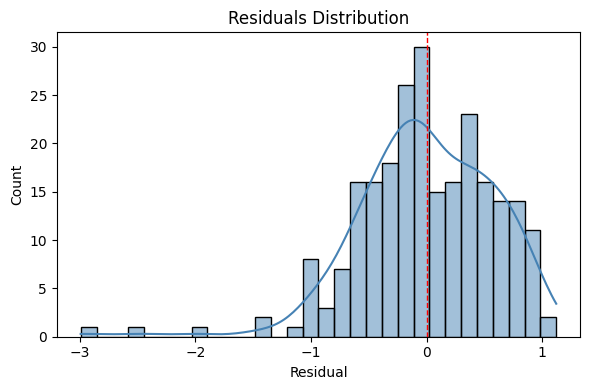

In [479]:
plot_residuals(y_test, y_pred_rf_l)

In [480]:
model_rf_a = RandomForestRegressor(random_state=42)
model_rf_a.fit(X_train_a_scaled, y_train)
y_pred_rf_a = model_rf_a.predict(X_test_a_scaled)

In [481]:
evaluate_regression_metrics_df(y_test, y_pred_rf_a)

,Metryka,Wartość
0,MSE,0.5821
1,RMSE,0.7629
2,RMSPE [%],34.6512
3,MAE,0.4461
4,MAPE [%],17.0522
5,R²,0.2681
6,Korelacja Pearsona,0.5200


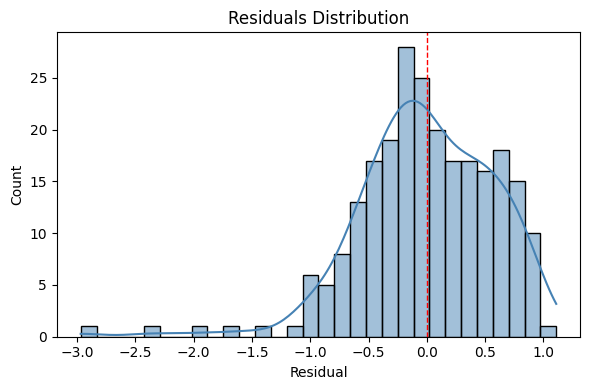

In [482]:
plot_residuals(y_test, y_pred_rf_a)

XGBoost

In [483]:
model_xgb_l = XGBRegressor()
model_xgb_l.fit(X_train_l_scaled, y_train)
y_pred_xgb_l = model_xgb_l.predict(X_test_l_scaled)

In [484]:
evaluate_regression_metrics_df(y_test, y_pred_xgb_l)

,Metryka,Wartość
0,MSE,0.6094
1,RMSE,0.7806
2,RMSPE [%],35.0427
3,MAE,0.4697
4,MAPE [%],17.9389
5,R²,0.1978
6,Korelacja Pearsona,0.4804


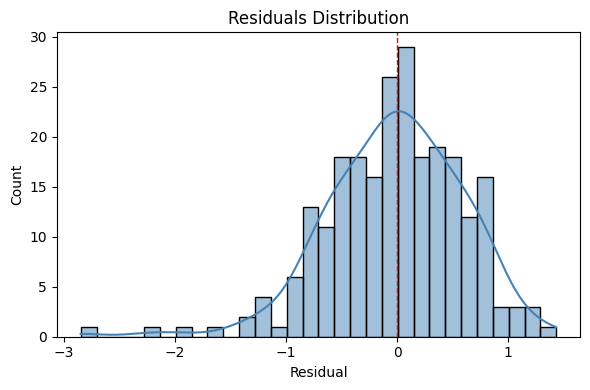

In [485]:
plot_residuals(y_test, y_pred_xgb_l)

In [486]:
model_xgb_a = XGBRegressor()
model_xgb_a.fit(X_train_a_scaled, y_train)
y_pred_xgb_a = model_xgb_a.predict(X_test_a_scaled)

In [487]:
evaluate_regression_metrics_df(y_test, y_pred_xgb_a)

,Metryka,Wartość
0,MSE,0.6230
1,RMSE,0.7893
2,RMSPE [%],37.6848
3,MAE,0.4693
4,MAPE [%],18.2251
5,R²,0.1615
6,Korelacja Pearsona,0.4435


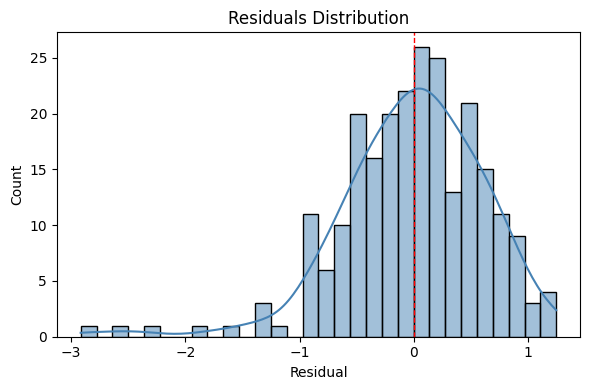

In [488]:
plot_residuals(y_test, y_pred_xgb_a)

SVR

In [489]:
model_svr_l = SVR()
model_svr_l.fit(X_train_l_scaled, y_train)
y_pred_svr_l = model_svr_l.predict(X_test_l_scaled)

In [490]:
evaluate_regression_metrics_df(y_test, y_pred_svr_l)

,Metryka,Wartość
0,MSE,0.6088
1,RMSE,0.7803
2,RMSPE [%],38.2999
3,MAE,0.4410
4,MAPE [%],17.4894
5,R²,0.1993
6,Korelacja Pearsona,0.4524


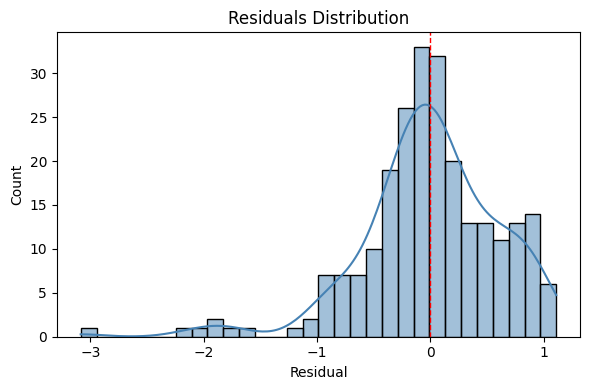

In [491]:
plot_residuals(y_test, y_pred_svr_l)

In [492]:
model_svr_a = SVR()
model_svr_a.fit(X_train_a_scaled, y_train)
y_pred_svr_a = model_svr_a.predict(X_test_a_scaled)

In [493]:
evaluate_regression_metrics_df(y_test, y_pred_svr_a)

,Metryka,Wartość
0,MSE,0.6043
1,RMSE,0.7774
2,RMSPE [%],38.0832
3,MAE,0.4421
4,MAPE [%],17.5112
5,R²,0.2111
6,Korelacja Pearsona,0.4644


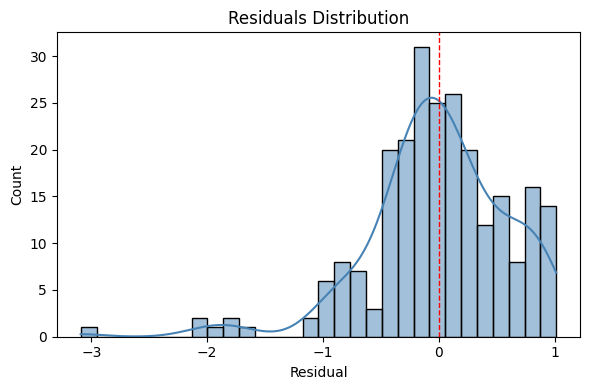

In [494]:
plot_residuals(y_test, y_pred_svr_a)

K-Nearest Neighbors Regressor

In [495]:
model_knn_l = KNeighborsRegressor()
model_knn_l.fit(X_train_l_scaled, y_train)
y_pred_knn_l = model_knn_l.predict(X_test_l_scaled)

In [496]:
evaluate_regression_metrics_df(y_test, y_pred_knn_l)

,Metryka,Wartość
0,MSE,0.5965
1,RMSE,0.7724
2,RMSPE [%],35.9069
3,MAE,0.4282
4,MAPE [%],16.8050
5,R²,0.2313
6,Korelacja Pearsona,0.4870


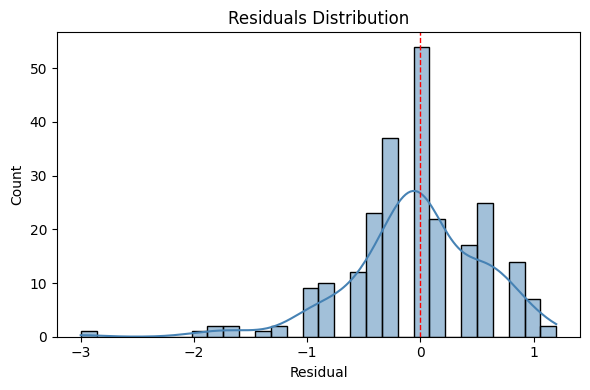

In [497]:
plot_residuals(y_test, y_pred_knn_l)

In [498]:
model_knn_a = KNeighborsRegressor()
model_knn_a.fit(X_train_a_scaled, y_train)
y_pred_knn_a = model_knn_a.predict(X_test_a_scaled)

In [499]:
evaluate_regression_metrics_df(y_test, y_pred_knn_a)

,Metryka,Wartość
0,MSE,0.6073
1,RMSE,0.7793
2,RMSPE [%],36.6327
3,MAE,0.4448
4,MAPE [%],17.4136
5,R²,0.2033
6,Korelacja Pearsona,0.4583


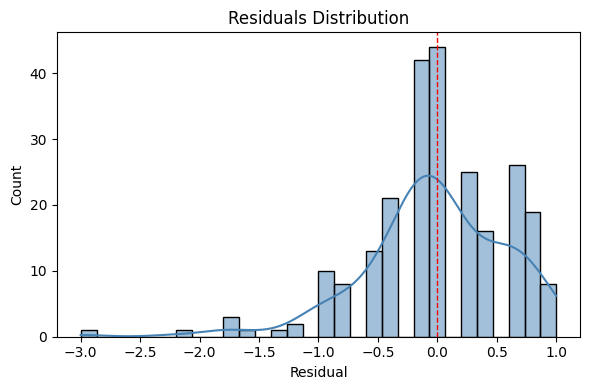

In [500]:
plot_residuals(y_test, y_pred_knn_a)

LassoCV

In [501]:
model_lasso_l = LassoCV()
model_lasso_l.fit(X_train_l_scaled, y_train)
y_pred_lasso_l = model_lasso_l.predict(X_test_l_scaled)

In [502]:
evaluate_regression_metrics_df(y_test, y_pred_lasso_l)

,Metryka,Wartość
0,MSE,0.5637
1,RMSE,0.7508
2,RMSPE [%],33.9379
3,MAE,0.4400
4,MAPE [%],16.8314
5,R²,0.3136
6,Korelacja Pearsona,0.5617


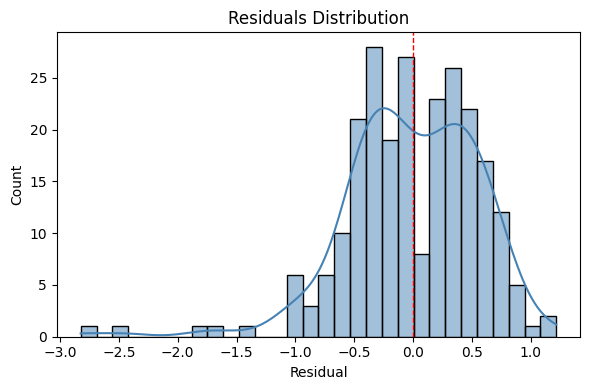

In [503]:
plot_residuals(y_test, y_pred_lasso_l)

In [504]:
model_lasso_a = LassoCV()
model_lasso_a.fit(X_train_a_scaled, y_train)
y_pred_lasso_a = model_lasso_a.predict(X_test_a_scaled)

In [505]:
evaluate_regression_metrics_df(y_test, y_pred_lasso_a)

,Metryka,Wartość
0,MSE,0.5635
1,RMSE,0.7506
2,RMSPE [%],33.9456
3,MAE,0.4398
4,MAPE [%],16.8285
5,R²,0.3141
6,Korelacja Pearsona,0.5623


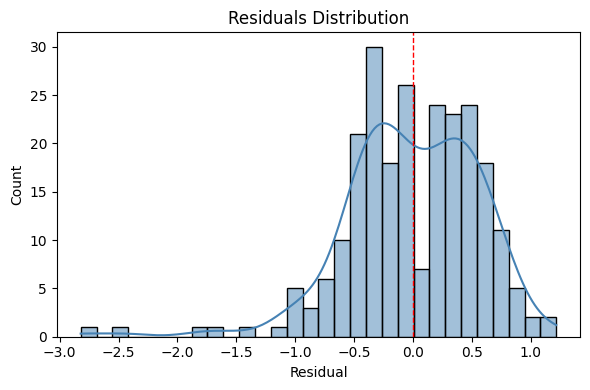

In [506]:
plot_residuals(y_test, y_pred_lasso_a)

Ridge

In [507]:
model_ridge_l = Ridge()
model_ridge_l.fit(X_train_l_scaled, y_train)
y_pred_ridge_l = model_ridge_l.predict(X_test_l_scaled)

In [508]:
evaluate_regression_metrics_df(y_test, y_pred_ridge_l)

,Metryka,Wartość
0,MSE,0.5631
1,RMSE,0.7504
2,RMSPE [%],33.6430
3,MAE,0.4378
4,MAPE [%],16.6894
5,R²,0.3151
6,Korelacja Pearsona,0.5616


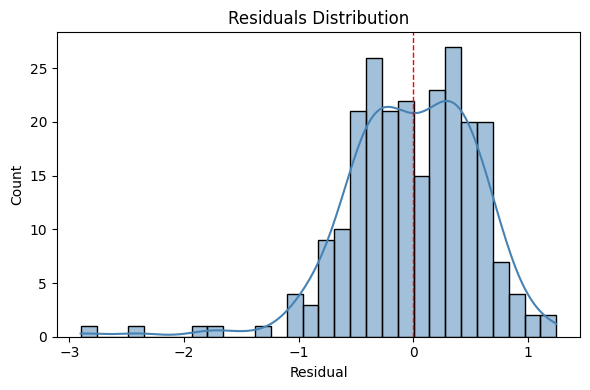

In [509]:
plot_residuals(y_test, y_pred_ridge_l)

In [510]:
model_ridge_a = Ridge()
model_ridge_a.fit(X_train_a_scaled, y_train)
y_pred_ridge_a = model_ridge_a.predict(X_test_a_scaled)

In [511]:
evaluate_regression_metrics_df(y_test, y_pred_ridge_a)

,Metryka,Wartość
0,MSE,0.5628
1,RMSE,0.7502
2,RMSPE [%],33.6968
3,MAE,0.4373
4,MAPE [%],16.7004
5,R²,0.3158
6,Korelacja Pearsona,0.5622


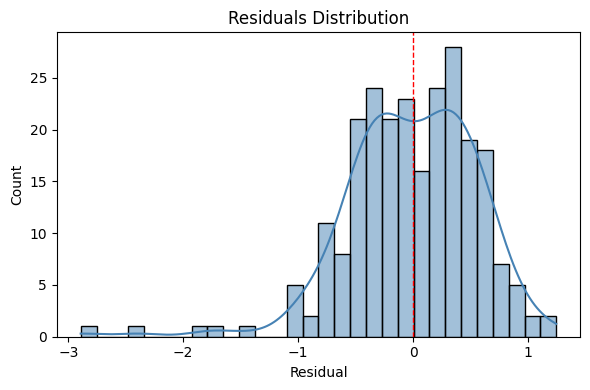

In [512]:
plot_residuals(y_test, y_pred_ridge_a)

Gradient Boosting Regressor

In [513]:
model_gbr_l = GradientBoostingRegressor()
model_gbr_l.fit(X_train_l_scaled, y_train)
y_pred_gbr_l = model_gbr_l.predict(X_test_l_scaled)

In [514]:
evaluate_regression_metrics_df(y_test, y_pred_gbr_l)

,Metryka,Wartość
0,MSE,0.5813
1,RMSE,0.7624
2,RMSPE [%],34.3264
3,MAE,0.4439
4,MAPE [%],16.9842
5,R²,0.2701
6,Korelacja Pearsona,0.5297


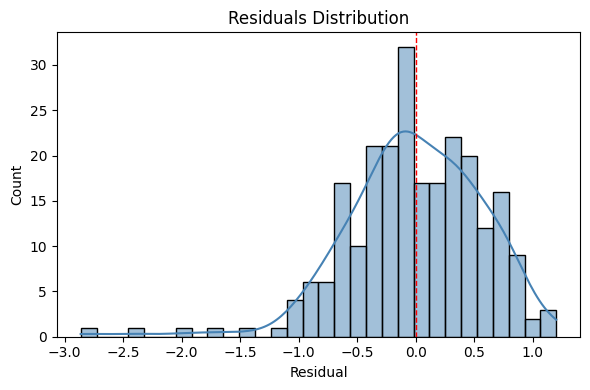

In [515]:
plot_residuals(y_test, y_pred_gbr_l)

In [516]:
model_gbr_a = GradientBoostingRegressor()
model_gbr_a.fit(X_train_a_scaled, y_train)
y_pred_gbr_a = model_gbr_a.predict(X_test_a_scaled)

In [517]:
evaluate_regression_metrics_df(y_test, y_pred_gbr_a)

,Metryka,Wartość
0,MSE,0.5775
1,RMSE,0.7599
2,RMSPE [%],34.6925
3,MAE,0.4375
4,MAPE [%],16.7972
5,R²,0.2796
6,Korelacja Pearsona,0.5330


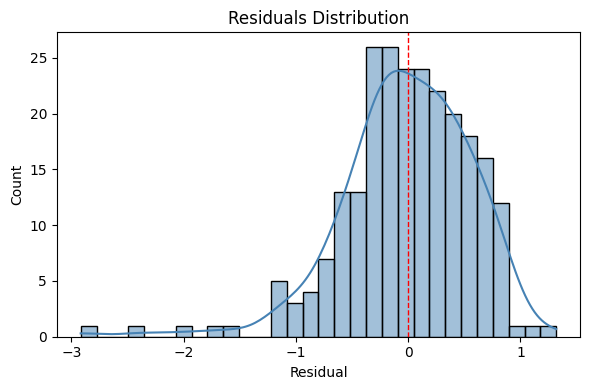

In [518]:
plot_residuals(y_test, y_pred_gbr_a)

Elastic Net

In [519]:
model_enc_l = ElasticNetCV()
model_enc_l.fit(X_train_l_scaled, y_train)
y_pred_enc_l = model_enc_l.predict(X_test_l_scaled)

In [520]:
evaluate_regression_metrics_df(y_test, y_pred_enc_l)

,Metryka,Wartość
0,MSE,0.5638
1,RMSE,0.7509
2,RMSPE [%],33.9704
3,MAE,0.4401
4,MAPE [%],16.8412
5,R²,0.3133
6,Korelacja Pearsona,0.5617


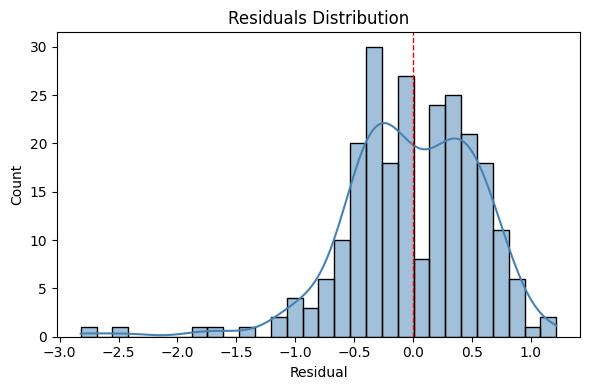

In [521]:
plot_residuals(y_test, y_pred_enc_l)

In [522]:
model_enc_a = ElasticNetCV()
model_enc_a.fit(X_train_a_scaled, y_train)
y_pred_enc_a = model_enc_a.predict(X_test_a_scaled)

In [523]:
evaluate_regression_metrics_df(y_test, y_pred_enc_a)

,Metryka,Wartość
0,MSE,0.5635
1,RMSE,0.7507
2,RMSPE [%],33.9638
3,MAE,0.4396
4,MAPE [%],16.8277
5,R²,0.3140
6,Korelacja Pearsona,0.5622


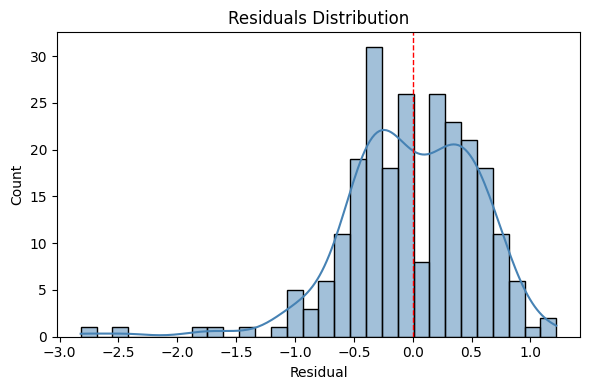

In [524]:
plot_residuals(y_test, y_pred_enc_a)

Summary

In [525]:
models = {
    "Linear Regression": ("model_reg_l", "model_reg_a"),
    "Random Forest": ("model_rf_l", "model_rf_a"),
    "XGBoost": ("model_xgb_l", "model_xgb_a"),
    "SVR": ("model_svr_l", "model_svr_a"),
    "K-Nearest Neighbors": ("model_knn_l", "model_knn_a"),
    "LassoCV": ("model_lasso_l", "model_lasso_a"),
    "Ridge": ("model_ridge_l", "model_ridge_a"),
    "Gradient Boosting": ("model_gbr_l", "model_gbr_a"),
    "Elastic Net CV": ("model_enc_l", "model_enc_a")
    }

In [526]:
X_tests = {
    "_l": X_test_l_scaled,
    "_a": X_test_a_scaled
}

In [527]:
y_test_vals = y_test.values

In [528]:
results = []

In [529]:
for model_name, (model_l_var, model_a_var) in models.items():
    for suffix, X_test_curr, model_var_name in [
        ("_l", X_tests["_l"], model_l_var),
        ("_a", X_tests["_a"], model_a_var)
    ]:
        model_obj = globals()[model_var_name]
        y_pred = model_obj.predict(X_test_curr)
        
        diffs = y_test_vals - y_pred
        rmse = np.sqrt(np.mean(diffs**2))
        mae = np.mean(np.abs(diffs))
        r2 = r2_score(y_test_vals, y_pred)
        pearson_r = np.corrcoef(y_test_vals, y_pred)[0, 1]
        
        results.append({
            "Model": model_name,
            "Predictor Set": "Likert-only" if suffix == "_l" else "Likert+Salary",
            "R2": round(r2, 3),
            "RMSE": round(rmse, 3),
            "MAE": round(mae, 3),
            "Pearson r": round(pearson_r, 3)
        })

In [530]:
results_df = pd.DataFrame(results)
results_df

,Model,Predictor Set,R2,RMSE,MAE,Pearson r
0,Linear Regression,Likert-only,0.315,0.563,0.438,0.562
1,Linear Regression,Likert+Salary,0.316,0.563,0.437,0.562
2,Random Forest,Likert-only,0.247,0.590,0.453,0.502
3,Random Forest,Likert+Salary,0.268,0.582,0.446,0.520
4,XGBoost,Likert-only,0.198,0.609,0.470,0.480
5,XGBoost,Likert+Salary,0.161,0.623,0.469,0.443
6,SVR,Likert-only,0.199,0.609,0.441,0.452
7,SVR,Likert+Salary,0.211,0.604,0.442,0.464
8,K-Nearest Neighbors,Likert-only,0.231,0.597,0.428,0.487
9,K-Nearest Neighbors,Likert+Salary,0.203,0.607,0.445,0.458


In [531]:
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
results_df

,Model,Predictor Set,R2,RMSE,MAE,Pearson r
1,Linear Regression,Likert+Salary,0.316,0.563,0.437,0.562
13,Ridge,Likert+Salary,0.316,0.563,0.437,0.562
0,Linear Regression,Likert-only,0.315,0.563,0.438,0.562
12,Ridge,Likert-only,0.315,0.563,0.438,0.562
10,LassoCV,Likert-only,0.314,0.564,0.440,0.562
11,LassoCV,Likert+Salary,0.314,0.563,0.440,0.562
17,Elastic Net CV,Likert+Salary,0.314,0.564,0.440,0.562
16,Elastic Net CV,Likert-only,0.313,0.564,0.440,0.562
15,Gradient Boosting,Likert+Salary,0.280,0.577,0.438,0.533
14,Gradient Boosting,Likert-only,0.270,0.581,0.444,0.530


Key observations: given the linear models' superior performance, data is mostly linear. The difference between linear regression and regularized models like LassoCV, Ridge is negligible. Complex models are performing significantly worse, meaning non-linearity is most likely noise. Salary feature has a small yet positive effect. Overall R2 is low, which is to be expected in social sciences. Multicollinearity is likely not a significant problem here.

In [532]:
models_to_plot = {
    "Linear Regression": (model_reg_a, X_test_a_scaled),
    "Ridge": (model_ridge_a, X_test_a_scaled),
    "LassoCV": (model_lasso_a, X_test_a_scaled),
    "Gradient Boosting": (model_gbr_a, X_test_a_scaled)
}

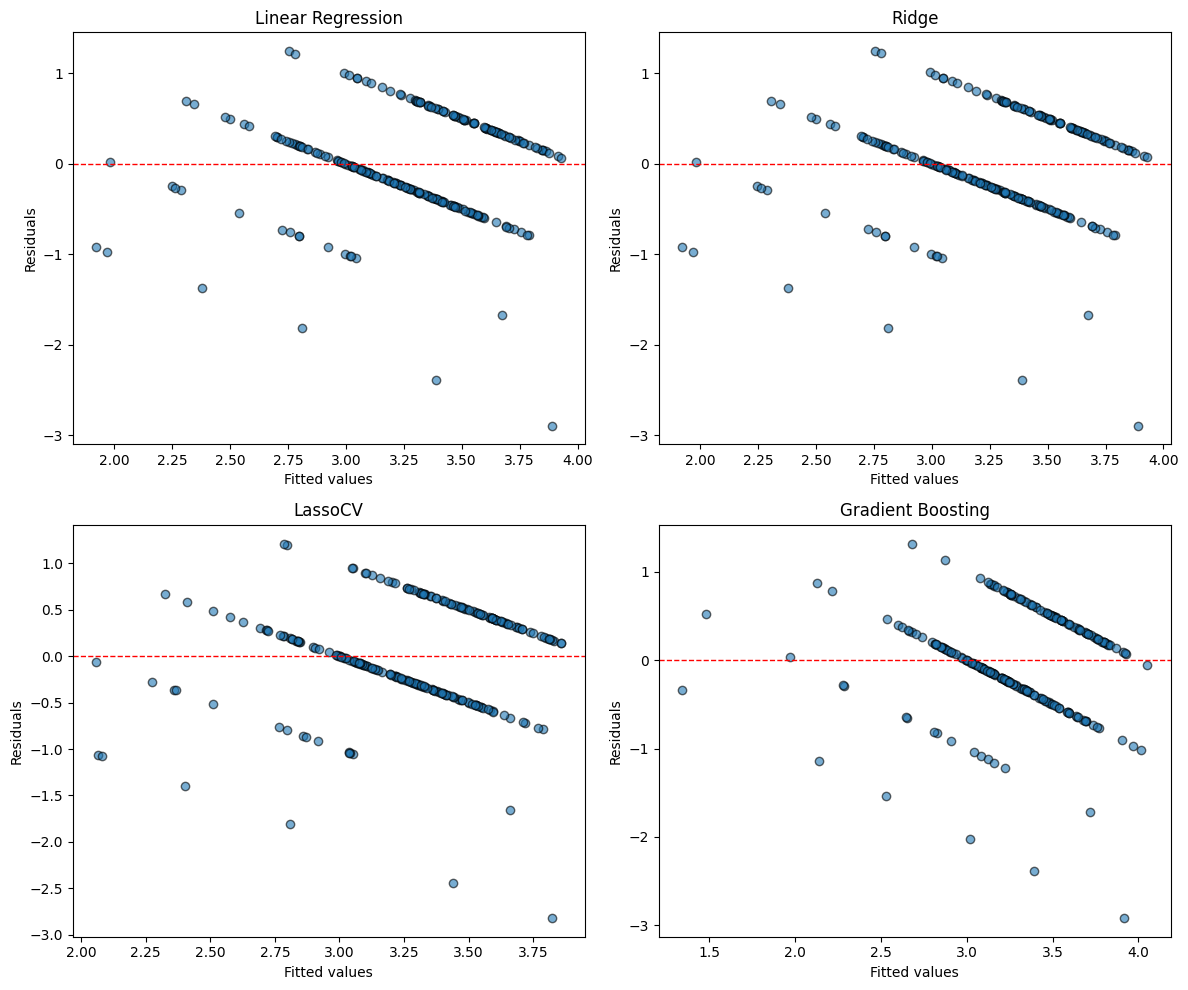

In [533]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, (model, X_test)) in zip(axes, models_to_plot.items()):
    y_pred = model.predict(X_test)
    residuals = y_test.values - y_pred
    
    ax.scatter(y_pred, residuals, alpha=0.6, edgecolor='k')
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Residuals")
    ax.set_title(name)

plt.tight_layout()
plt.show()

Residuals and fitted value distributions indicate a potential omitted variable bias, potentially a categorical variable with 2-4 values. Running a Ramsey test to verify this:

In [534]:
model = sm.OLS(y_train, X_train_all).fit()
sm.stats.durbin_watson(model.resid)  
sm.stats.linear_reset(model, power=2, use_f=True)  

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=37.35660639740693, p=1.4433819842066154e-09, df_denom=934, df_num=1>

The Ramsey RESET test (F = 59.0, p < 0.001) indicated potential model mis-specification, suggesting that nonlinear effects or omitted variables may influence the dependent variable.

Checking potential omitted variables

In [535]:
#checks for the omitted variable

Gender

In [536]:
X_all_gender = survey_selected_df[likert_predictors + salary_predictor + ["g8"]]

In [537]:
X_train_ag, X_test_ag, y_train, y_test = train_test_split(
    X_all_gender, y, test_size=0.2, random_state=42
)

In [538]:
model_reg_ag = LinearRegression()
model_reg_ag.fit(X_train_ag, y_train)
y_pred_reg_ag = model_reg_ag.predict(X_test_ag)

In [539]:
evaluate_regression_metrics_df(y_test, y_pred_reg_ag)

,Metryka,Wartość
0,MSE,0.5631
1,RMSE,0.7504
2,RMSPE [%],33.7354
3,MAE,0.4375
4,MAPE [%],16.7110
5,R²,0.3149
6,Korelacja Pearsona,0.5615


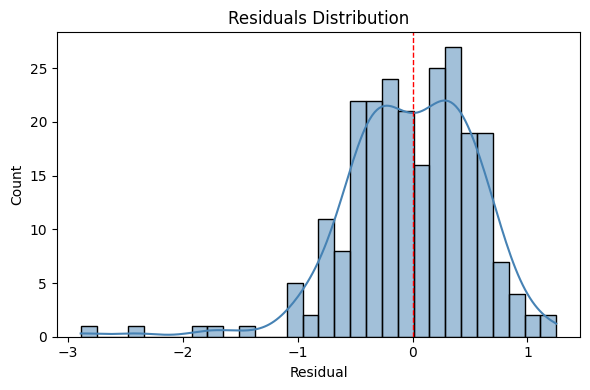

In [540]:
plot_residuals(y_test, y_pred_reg_ag)

Given the exploratory and pedagogical scope of this project, the current model is considered an acceptable approximation, with omitted variable analysis marked for future refinement.

Tuning

In [541]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
model_ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
model_ridge_cv.fit(X_train_a_scaled, y_train)

print("Best alpha:", model_ridge_cv.alpha_)
print("CV R²:", model_ridge_cv.best_score_)
print("Test R²:", model_ridge_cv.score(X_test_a_scaled, y_test))

Best alpha: 100.0
CV R²: 0.3214414055508305
Test R²: 0.3147588051214725


In [542]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Fit ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=42)
enet_cv.fit(X_train_a_scaled, y_train)

# Results
print("Best alpha:", enet_cv.alpha_)
print("Best l1_ratio:", enet_cv.l1_ratio_)
print("CV R²:", enet_cv.score(X_train_a_scaled, y_train))
print("Test R²:", enet_cv.score(X_test_a_scaled, y_test))

Best alpha: 0.01
Best l1_ratio: 1.0
CV R²: 0.3699594688665634
Test R²: 0.31440704757750104


Deciding on the model

In [543]:
results = []

results.append({
    "Model": "Linear Regression",
    "Best α": None,
    "Best l1_ratio": None,
    "CV R²": None,
    "Test R²": r2_score(y_test, y_pred_reg_a),
    "RMSE": root_mean_squared_error(y_test, y_pred_reg_a),
    "MAE": mean_absolute_error(y_test, y_pred_reg_a),
    "Pearson r": np.corrcoef(y_test, y_pred_reg_a)[0, 1]
})

results.append({
    "Model": "Ridge (Baseline)",
    "Best α": getattr(model_ridge_a, "alpha", None),
    "Best l1_ratio": None,
    "CV R²": None,
    "Test R²": r2_score(y_test, y_pred_ridge_a),
    "RMSE": root_mean_squared_error(y_test, y_pred_ridge_a),
    "MAE": mean_absolute_error(y_test, y_pred_ridge_a),
    "Pearson r": np.corrcoef(y_test, y_pred_ridge_a)[0, 1]
})

results.append({
    "Model": "RidgeCV (Tuned)",
    "Best α": model_ridge_cv.alpha_,
    "Best l1_ratio": None,
    "CV R²": model_ridge_cv.best_score_,
    "Test R²": model_ridge_cv.score(X_test_a_scaled, y_test),
    "RMSE": root_mean_squared_error(y_test, model_ridge_cv.predict(X_test_a_scaled)),
    "MAE": mean_absolute_error(y_test, model_ridge_cv.predict(X_test_a_scaled)),
    "Pearson r": np.corrcoef(y_test, model_ridge_cv.predict(X_test_a_scaled))[0, 1]
})

results.append({
    "Model": "ElasticNetCV (Tuned)",
    "Best α": enet_cv.alpha_,
    "Best l1_ratio": enet_cv.l1_ratio_,
    "CV R²": enet_cv.score(X_train_a_scaled, y_train),
    "Test R²": enet_cv.score(X_test_a_scaled, y_test),
    "RMSE": root_mean_squared_error(y_test, enet_cv.predict(X_test_a_scaled)),
    "MAE": mean_absolute_error(y_test, enet_cv.predict(X_test_a_scaled)),
    "Pearson r": np.corrcoef(y_test, enet_cv.predict(X_test_a_scaled))[0, 1]
})

df_results = pd.DataFrame(results)
df_results.style.format(precision=4)

,Model,Best α,Best l1_ratio,CV R²,Test R²,RMSE,MAE,Pearson r
0,Linear Regression,nan,nan,nan,0.3157,0.5628,0.4373,0.5622
1,Ridge (Baseline),1.0000,nan,nan,0.3158,0.5628,0.4373,0.5622
2,RidgeCV (Tuned),100.0000,nan,0.3214,0.3148,0.5632,0.4374,0.5617
3,ElasticNetCV (Tuned),0.0100,1.0000,0.3700,0.3144,0.5634,0.4390,0.5617


Selecting RidgeCV for its stability

SHAP

In [544]:
explainer = shap.Explainer(model_ridge_cv, X_train_a_scaled)
shap_values_train = explainer(X_train_a_scaled)
shap_values_test = explainer(X_test_a_scaled)

In [545]:
desc_map = dict(zip(variables_info["Variable"], variables_info["Description"]))
dict_names = [
    f"{col} — {desc_map.get(col, '')}" for col in X_train_all.columns
]

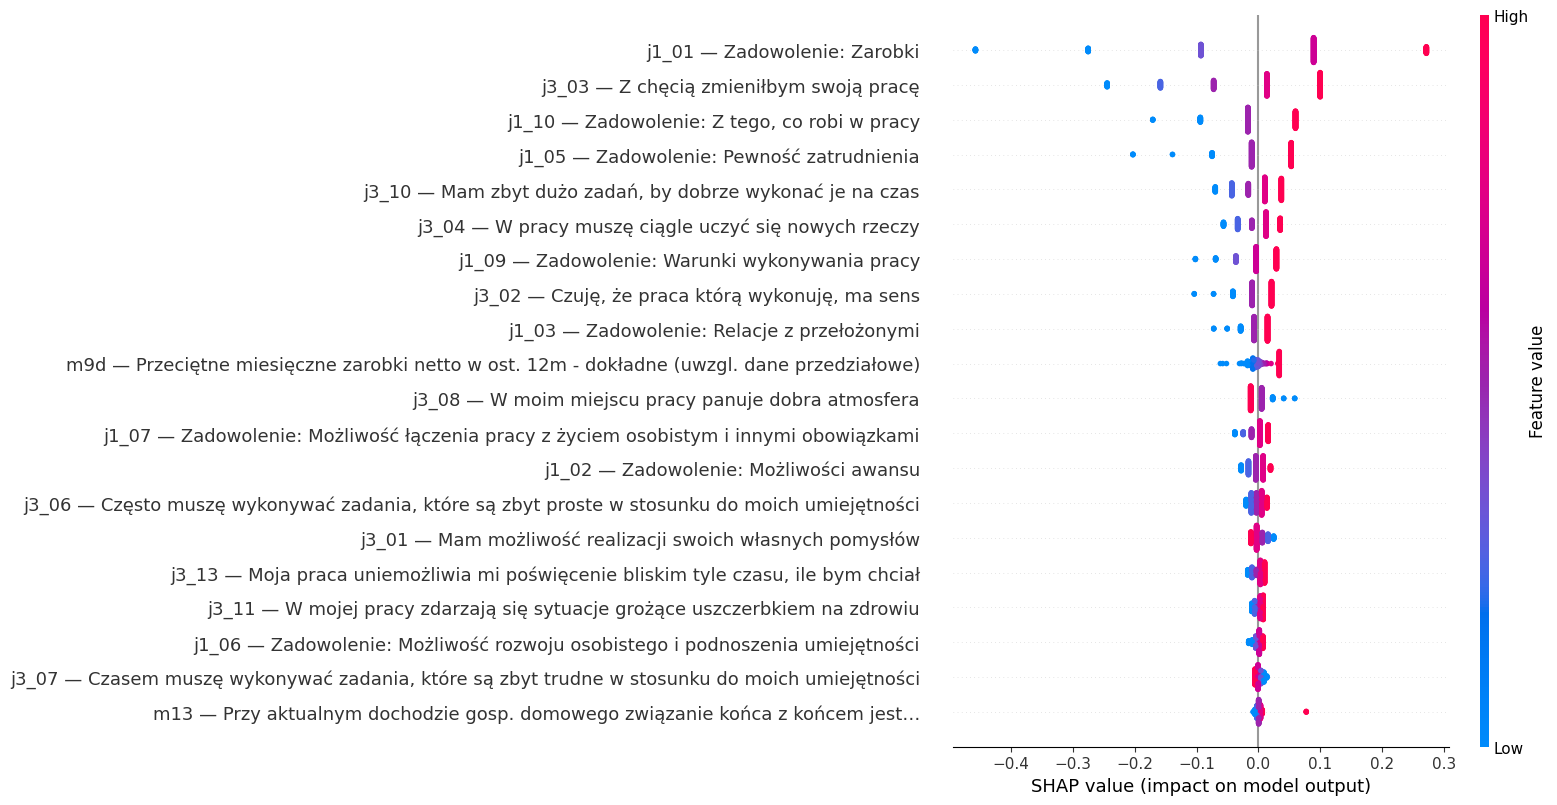

In [546]:
shap.summary_plot(
    shap_values_test, 
    X_test_a_scaled,
    feature_names = dict_names 
)

From the graph, we can observe that the variable with the strongest impact is personal satisfaction with earnings, measured on a 1-5 Likert scale. Interestingly, this factor is a stronger predictor than respondents’ actual income levels.

Two other strong positive predictors are satisfaction with one’s actual work tasks and employment security. The strongest negative predictor - unsurprisingly - is the desire to change jobs.

Among other notable predictors, a positive one is the need to continuously learn at work, while a negative one is having too many tasks to complete within deadlines.

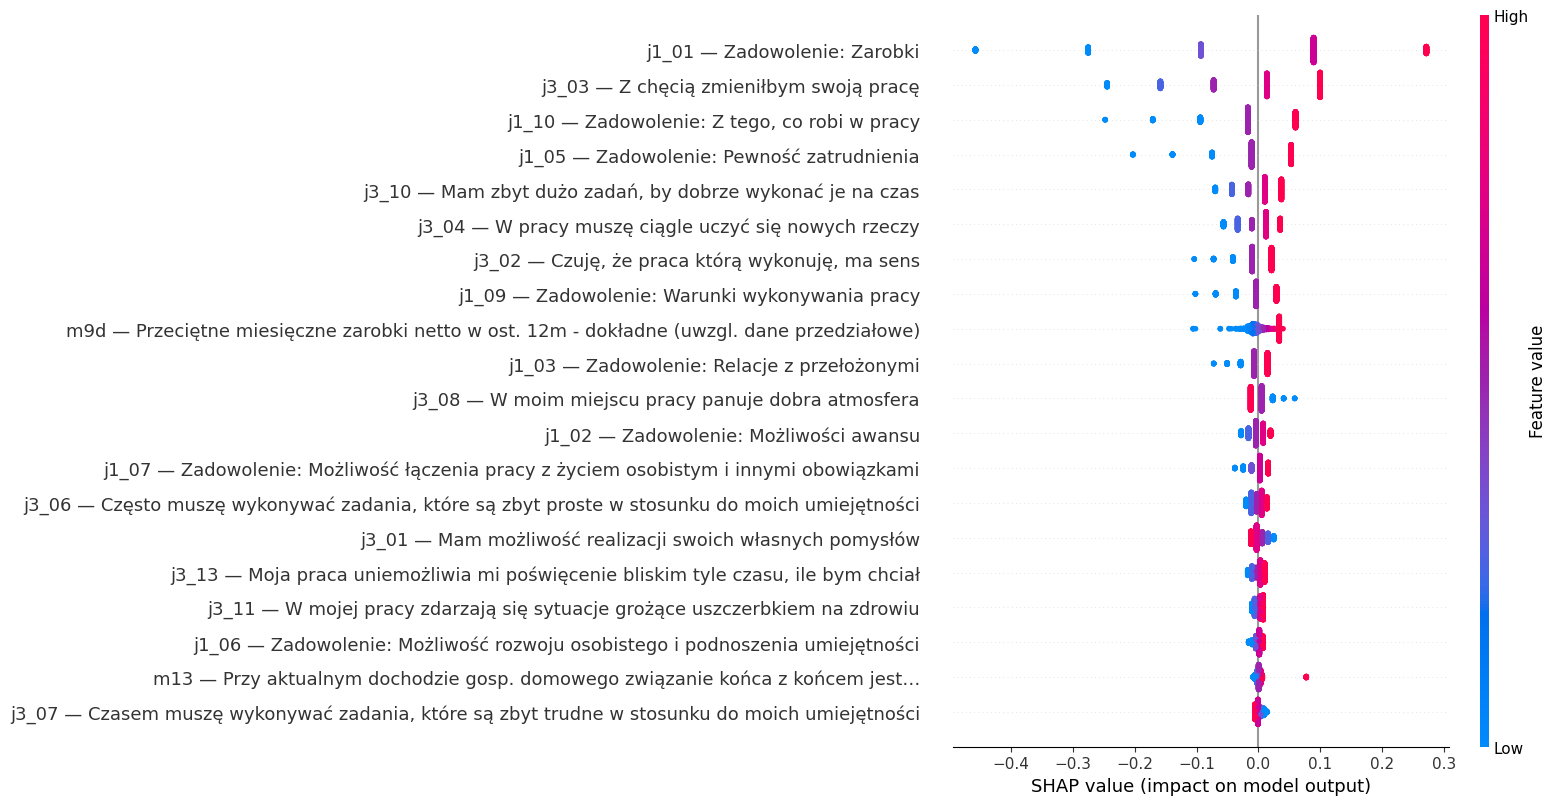

In [547]:
shap.summary_plot(
    shap_values_train, 
    X_train_a_scaled,
    feature_names = dict_names 
)

The SHAP summary plots for train and test data look almost identical. To verify that the SHAP values were truly different, the correlation of mean absolute SHAP values per feature was calculated.

In [553]:
train_means = np.abs(shap_values_train.values).mean(axis=0)
test_means = np.abs(shap_values_test.values).mean(axis=0)
correlation = np.corrcoef(train_means, test_means)[0,1]

print("Correlation of mean absolute SHAP values (train vs test):", correlation)

Correlation of mean absolute SHAP values (train vs test): 0.99934305711213


The correlation is extremely high (~0.999), which is expected for a linear model on standardized features.

In [554]:
x_instance = pd.DataFrame(
    X_test_a_scaled[0].reshape(1, -1),
    columns=X_train_all.columns
)
shap_values_single = explainer(x_instance)
#beeswarm consideration

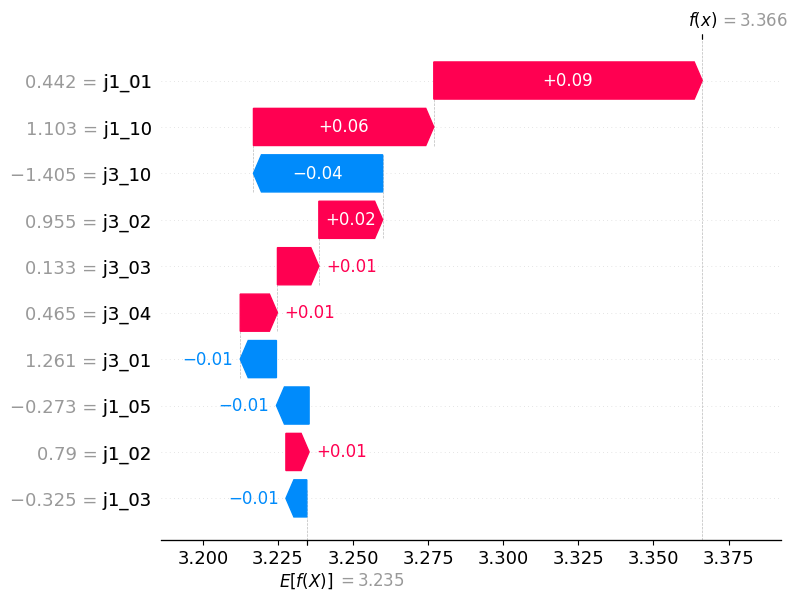

,Code,Description
0,j1_01,Zadowolenie: Zarobki
1,j1_10,"Zadowolenie: Z tego, co robi w pracy"
2,j3_10,"Mam zbyt dużo zadań, by dobrze wykonać je na czas"
3,j3_02,"Czuję, że praca którą wykonuję, ma sens"
4,j3_03,Z chęcią zmieniłbym swoją pracę
5,j3_04,W pracy muszę ciągle uczyć się nowych rzeczy
6,j3_01,Mam możliwość realizacji swoich własnych pomysłów
7,j1_05,Zadowolenie: Pewność zatrudnienia
8,j1_02,Zadowolenie: Możliwości awansu
9,j1_03,Zadowolenie: Relacje z przełożonymi


In [555]:
top_idx = np.argsort(np.abs(shap_values_single.values[0]))[::-1][:10]
shap.plots.waterfall(shap_values_single[0][top_idx])

top_features = X_train_all.columns[top_idx]

feature_table = pd.DataFrame({
    "Code": top_features,
    "Description": [variables_info.loc[variables_info.Variable==c, "Description"].values[0] 
                    for c in top_features]
})

display(feature_table)

# Clustering

PCA and clustering were performed on the training dataset (960 samples) because it provides a more stable estimate of variance and better representation of the data structure.

In [556]:
shap_values_df = pd.DataFrame(shap_values_train.values, columns=X_train_all.columns)
print(shap_values_df.isnull().values.any())

False


In [557]:
scaler = StandardScaler()
shap_scaled = scaler.fit_transform(shap_values_df)
print(shap_values_df)

        j1_01     j1_02     j1_03     j1_04     j1_05     j1_06     j1_07  \
0   -0.093005 -0.004162 -0.006962  0.002304 -0.010885  0.001482  0.002430   
1    0.089358 -0.027946  0.014794  0.002304 -0.010885  0.007181  0.015931   
2    0.089358  0.007730 -0.006962 -0.001810 -0.010885  0.001482  0.002430   
3   -0.093005 -0.016054 -0.006962  0.002304  0.053144 -0.004217 -0.011071   
4    0.089358  0.007730  0.014794  0.002304  0.053144  0.001482  0.015931   
..        ...       ...       ...       ...       ...       ...       ...   
955  0.089358 -0.004162  0.014794  0.002304 -0.010885  0.001482  0.002430   
956 -0.093005 -0.004162 -0.028718 -0.005925 -0.074914 -0.004217 -0.011071   
957 -0.093005 -0.004162 -0.006962  0.002304 -0.074914  0.001482  0.002430   
958 -0.093005 -0.004162  0.014794  0.002304  0.053144  0.001482 -0.011071   
959  0.089358 -0.004162  0.014794 -0.001810 -0.010885  0.001482  0.002430   

        j1_08     j1_09     j1_10  ...     j3_06     j3_07     j3_08  \
0  

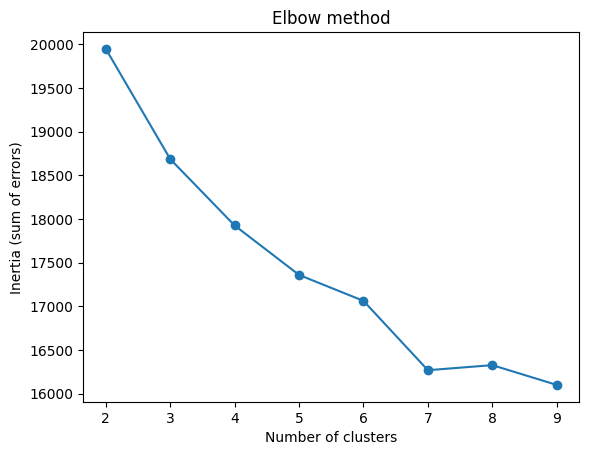

In [558]:
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(shap_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (sum of errors)')
plt.title('Elbow method')
plt.show()

In [559]:
k = 7 
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(shap_scaled)

shap_values_df['cluster'] = clusters

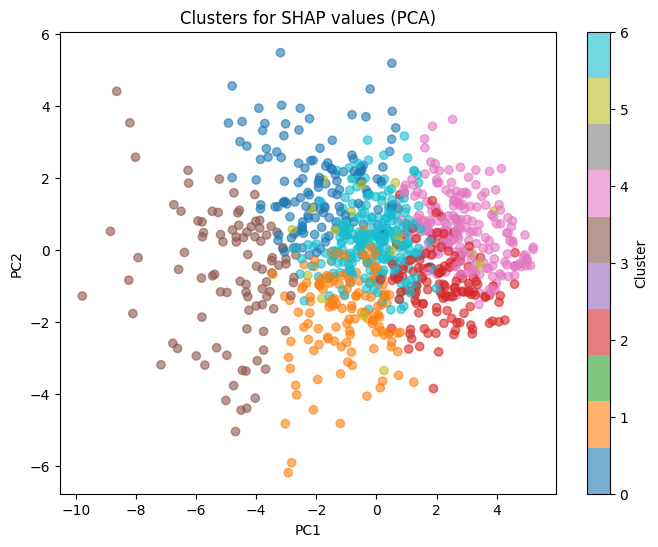

In [560]:
pca = PCA(n_components=2)
shap_2d = pca.fit_transform(shap_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(shap_2d[:, 0], shap_2d[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title("Clusters for SHAP values (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [561]:
cluster_profiles = shap_values_df.groupby('cluster').mean()

In [563]:
shap_values_df['satisfaction'] = y_train.values

cluster_summary = shap_values_df.groupby('cluster')['satisfaction'].agg(['mean', 'std', 'count'])
print(cluster_summary)

             mean       std  count
cluster                           
0        2.992366  0.547669    131
1        3.094203  0.450266    138
2        3.430657  0.603856    137
3        2.604167  0.703063     96
4        3.613065  0.518380    199
5        3.277778  0.751904     18
6        3.302905  0.486861    241


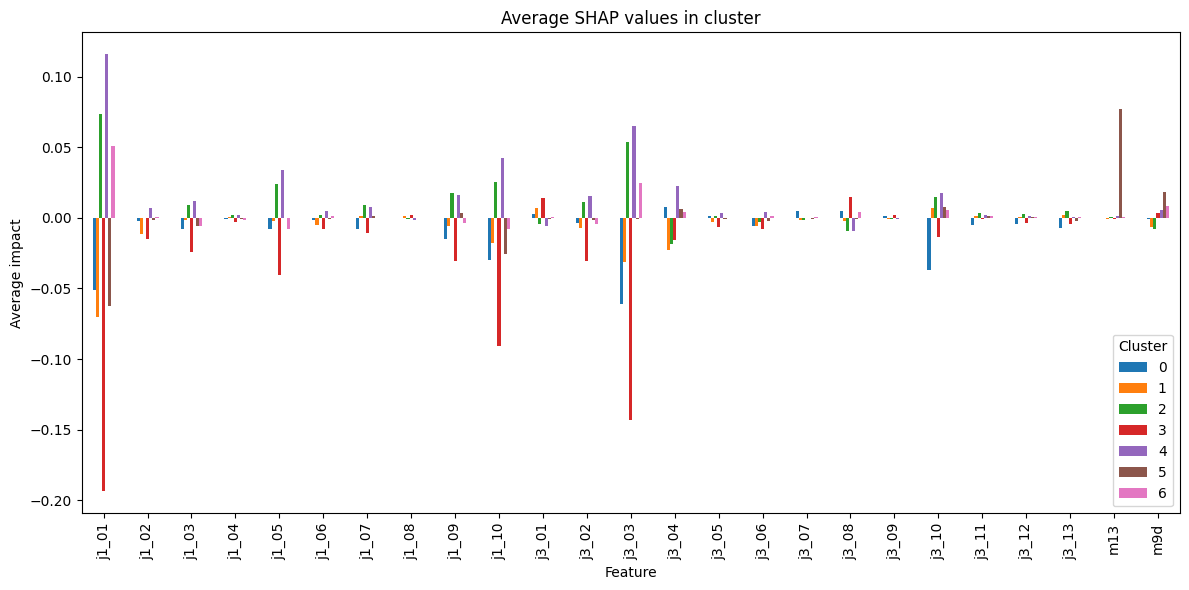

In [564]:
cluster_profiles.T.plot(kind='bar', figsize=(12, 6))
plt.title("Average SHAP values in cluster")
plt.xlabel("Feature")
plt.ylabel("Average impact")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

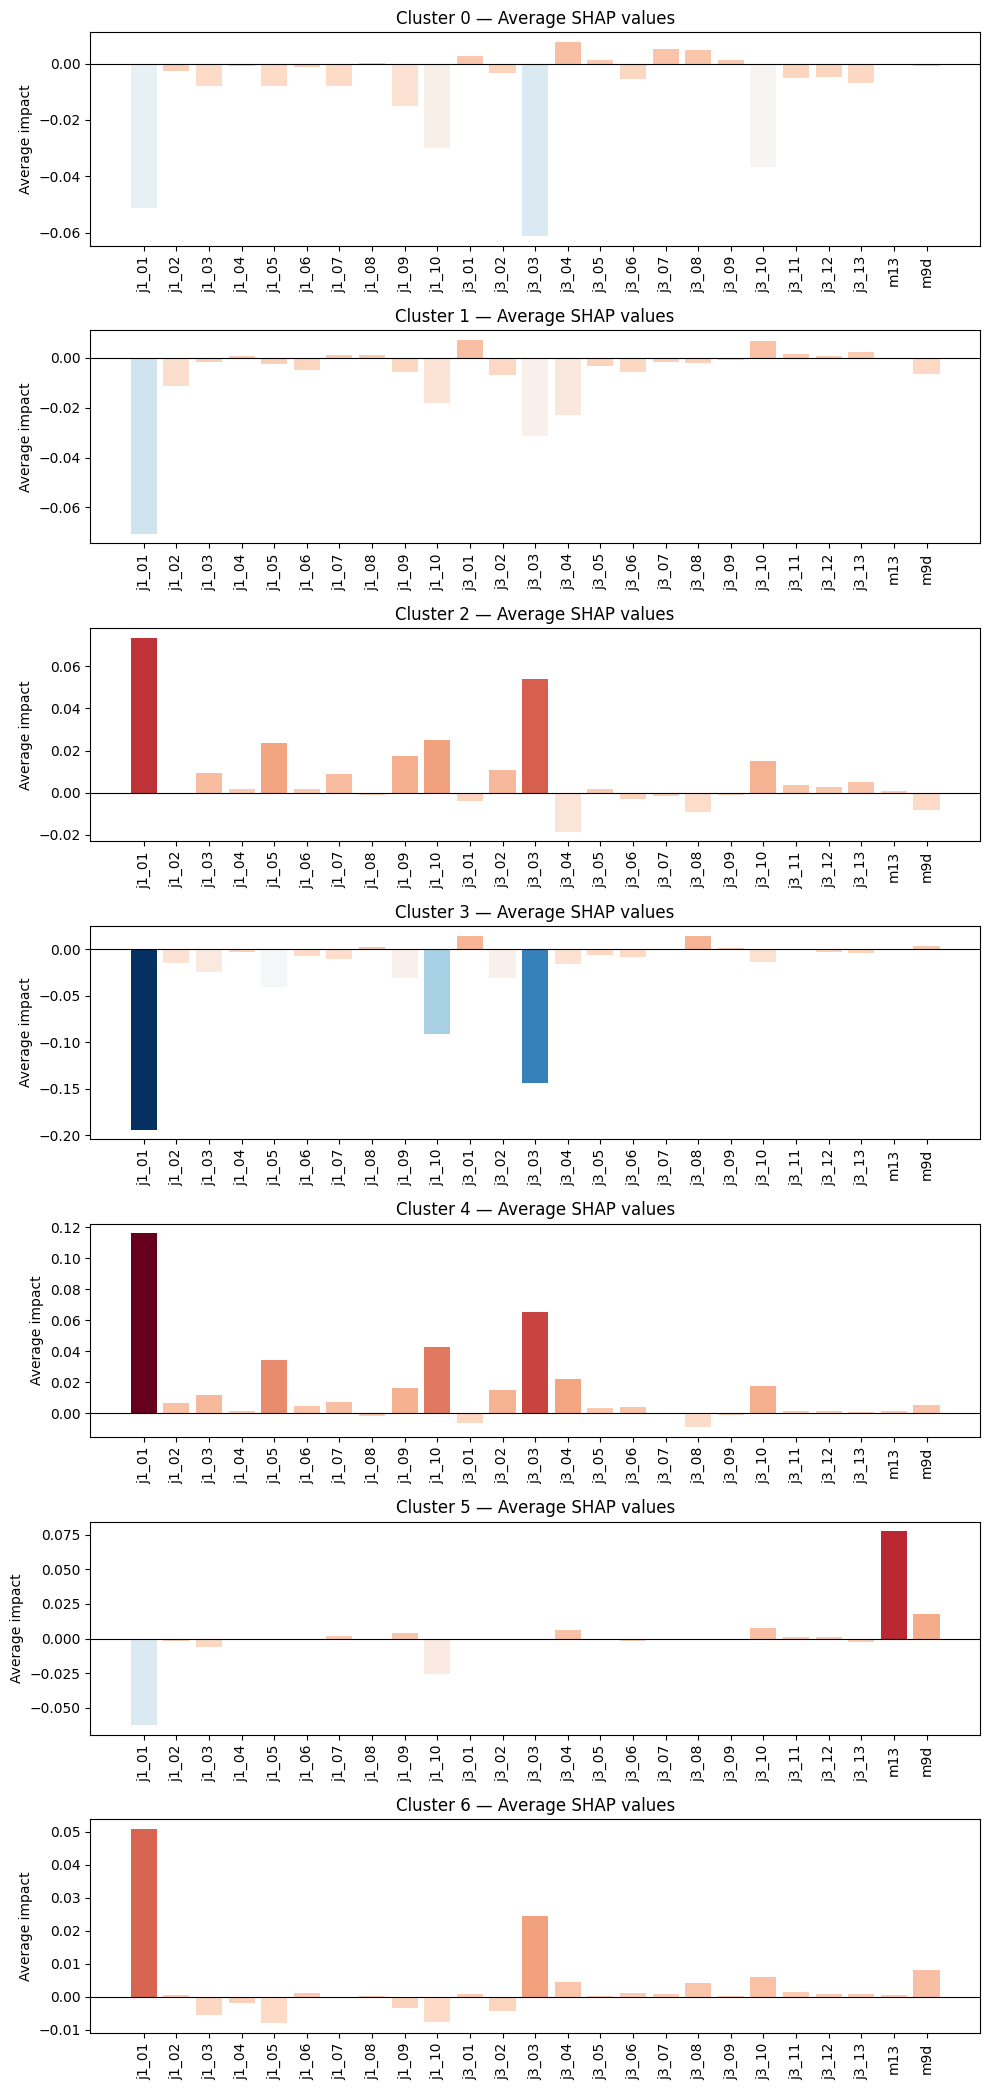

In [569]:
clusters_sorted = sorted(shap_values_df['cluster'].unique())

cmap = cm.get_cmap('RdBu_r')  # reversed so red=positive, blue=negative
vmax = cluster_profiles.values.max()
vmin = cluster_profiles.values.min()

fig, axes = plt.subplots(nrows=len(clusters_sorted), figsize=(10, 3 * len(clusters_sorted)))

for i, cluster_id in enumerate(clusters_sorted):
    ax = axes[i]
    vals = cluster_profiles.loc[cluster_id]
    colors = [cmap((v - vmin) / (vmax - vmin)) for v in vals.values]
    ax.bar(vals.index, vals.values, color=colors)
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"Cluster {cluster_id} — Average SHAP values")
    ax.set_ylabel("Average impact")
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Cluster-Level Analysis of Job Satisfaction (Based on SHAP Values)

| Cluster | Mean Satisfaction | Std. Dev. | n  | Summary Description |
|:--------:|:----------------:|:----------:|:--:|:--------------------|
| **4 (Happy Core)** | **3.61** | 0.52 | 199 | *The “Goal-Driven Satisfied.”* Highest overall satisfaction. Strongest positive impact from **earnings (j1_01)**, **job meaning (j3_02)**, and **learning opportunities (j3_04)**. Mild negative impact of *good atmosphere* (j3_08) and *carrying out own ideas* (j3_01) suggests their satisfaction depends more on extrinsic structure (pay, stability) than soft factors. |
| **2 (Satisfied Baseline)** | **3.43** | 0.60 | 137 | *The “Conditions & Stability Satisfied.”* High satisfaction driven by **pay (j1_01)**, **job stability (j1_05)**, and **work conditions (j1_09)**. Mild negative impact of *learning new things (j3_04)* - they value comfort and balance over novelty. |
| **6 (Financially Motivated)** | **3.30** | 0.49 | 241 | *Largest cluster.* Satisfaction is tied to both **subjective pay satisfaction (j1_01)** and **actual income (m9d)**. Other mild positive predictors: *good atmosphere (j3_08)* and *manageable workload (j3_10)*. Indicates strong financial orientation. |
| **5 (Survivalists / At-Risk)** | **3.28** | 0.75 | 18 | *Smallest cluster.* Dominated by **m13 (ease of making ends meet)** as the key predictor - job satisfaction closely tied to financial security. Large variability (σ = 0.75) reflects heterogeneity in this small group. |
| **1 (Homogeneously Disengaged)** | **3.09** | 0.45 | 138 | *Low variation, slightly below-average satisfaction.* Negative SHAP impacts from **earnings (j1_01)** and **learning (j3_04)** suggest disinterest in development. Prefer predictable, stable work but remain only moderately satisfied. |
| **0 (Dissatisfied Status Quo)** | **2.99** | 0.55 | 131 | *Moderately dissatisfied.* Negative impacts from **earnings (j1_01)** and **work engagement (j3_03)** imply they remain unhappy despite positive conditions. Slight positive from *learning new things (j3_04)* hints at some latent motivation for growth. |
| **3 (Trapped / Compensated Dissatisfied)** | **2.60** | 0.70 | 96 | *Most dissatisfied cluster.* Strong negative SHAP effects for **pay satisfaction (j1_01)** and **unwillingness to leave (j3_03)** - suggesting employees stay despite deep dissatisfaction (“compensated dissatisfaction”). Only mild positives: *autonomy (j3_01)* and *good atmosphere (j3_08).* |

---

#### Key Patterns & Interpretations

- **Reversed Predictors (Clusters 0, 1, 3):** For these groups, satisfaction with earnings (*j1_01*) and retention intent (*j3_03*) show **negative** SHAP impacts - a “compensated dissatisfaction” pattern where higher pay does not translate into happiness.
- **Financial Sensitivity (Clusters 4, 5, 6):** Satisfaction is **strongly driven by financial factors** - either perceived (j1_01) or objective (m9d, m13).
- **Learning and Growth:** Interest in self-development differentiates clusters.  
  - Positive in **Cluster 0** and **Cluster 4**  
  - Negative in **Cluster 1** and **Cluster 2**
- **Atmosphere and Autonomy:** Only **Cluster 3** shows clear improvement from a *good atmosphere* and *autonomy*, reinforcing that social and creative support matter most for the most dissatisfied.


#### Notable SHAP Insight Example
> *For clusters 0, 1, and 3, satisfaction with earnings (j1_01) has a significant inverse relationship with overall job satisfaction. This suggests a “compensated dissatisfaction” dynamic where higher pay acts as a counterbalance for deeper discontent.*


#### Overall Summary
Across the clusters, job satisfaction divides into three broad patterns:
1. **Financially anchored satisfaction** (Clusters 4, 5, 6)  
2. **Stability/condition-based satisfaction** (Cluster 2)  
3. **Compensated dissatisfaction** (Clusters 0, 1, 3)

Overall, these clusters reveal that people find satisfaction in very different ways — some through pay and stability, others despite them.

In [184]:
feature_labels = pd.DataFrame({
    "Variable": cluster_profiles.columns,  
}).merge(variables_info, on="Variable", how="left")

display(feature_labels)

,Variable,Description
0,j1_01,Zadowolenie: Zarobki
1,j1_02,Zadowolenie: Możliwości awansu
2,j1_03,Zadowolenie: Relacje z przełożonymi
3,j1_04,Zadowolenie: Kontakty ze współpracownikami
4,j1_05,Zadowolenie: Pewność zatrudnienia
5,j1_06,Zadowolenie: Możliwość rozwoju osobistego i podnoszenia umiejętności
6,j1_07,Zadowolenie: Możliwość łączenia pracy z życiem osobistym i innymi obowiązkami
7,j1_08,Zadowolenie: Możliwość wykazania się inicjatywą i samodzielnością
8,j1_09,Zadowolenie: Warunki wykonywania pracy
9,j1_10,"Zadowolenie: Z tego, co robi w pracy"


Assessing the quality of clusterization

In [570]:
ch = calinski_harabasz_score(shap_scaled, clusters)
db = davies_bouldin_score(shap_scaled, clusters)

print(f"Calinski-Harabasz: {ch:.2f}")
print(f"Davies-Bouldin: {db:.2f}")

Calinski-Harabasz: 75.47
Davies-Bouldin: 2.63


**Assessing intergenerational differences**

In [575]:
#Average satisfaction
predictor_cols_for_avg = likert_predictors + ['satisfaction']
avg_satisfaction_by_generation = survey_selected_df.groupby('generation')[predictor_cols_for_avg].mean().reindex(['BB', 'X', 'M', 'Z', 'A'])
print("\nAverage satisfaction, by generation:")
print(avg_satisfaction_by_generation)


Average satisfaction, by generation:
               j1_01     j1_02     j1_03     j1_04     j1_05     j1_06  \
generation                                                               
BB          3.403846  2.980769  4.237179  4.435897  4.352564  3.653846   
X           3.422472  3.080899  4.249438  4.408989  4.155056  3.698876   
M           3.700000  3.254545  4.218182  4.415909  4.263636  3.720455   
Z           3.825000  3.350000  4.406250  4.562500  4.262500  3.843750   
A                NaN       NaN       NaN       NaN       NaN       NaN   

               j1_07     j1_08     j1_09     j1_10  ...     j3_06     j3_07  \
generation                                          ...                       
BB          3.839744  3.993590  4.025641  4.237179  ...  2.967949  3.794872   
X           3.892135  4.002247  4.031461  4.134831  ...  3.224719  3.741573   
M           3.900000  4.040909  4.118182  4.127273  ...  3.165909  3.743182   
Z           3.843750  4.100000  4.218750  4.2437

In [576]:
avg_satisfaction_by_generation.head()

,j1_01,j1_02,j1_03,j1_04,j1_05,j1_06,j1_07,j1_08,j1_09,j1_10,...,j3_06,j3_07,j3_08,j3_09,j3_10,j3_11,j3_12,j3_13,m13,satisfaction
generation,,,,,,,,,,,,,,,,,,,,,
BB,3.403846,2.980769,4.237179,4.435897,4.352564,3.653846,3.839744,3.993590,4.025641,4.237179,...,2.967949,3.794872,4.339744,4.217949,3.692308,3.339744,3.467949,3.583333,3.903846,3.192308
X,3.422472,3.080899,4.249438,4.408989,4.155056,3.698876,3.892135,4.002247,4.031461,4.134831,...,3.224719,3.741573,4.312360,4.339326,3.669663,3.368539,3.516854,3.485393,4.186517,3.231461
M,3.700000,3.254545,4.218182,4.415909,4.263636,3.720455,3.900000,4.040909,4.118182,4.127273,...,3.165909,3.743182,4.293182,4.327273,3.640909,3.581818,3.763636,3.572727,4.881818,3.261364
Z,3.825000,3.350000,4.406250,4.562500,4.262500,3.843750,3.843750,4.100000,4.218750,4.243750,...,3.125000,3.756250,4.456250,4.525000,3.687500,3.718750,4.025000,3.687500,4.696875,3.287500
A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [579]:
#Dropping gen alpha, since we have no data on them
avg_satisfaction_by_generation_clean = avg_satisfaction_by_generation.drop(index='A')

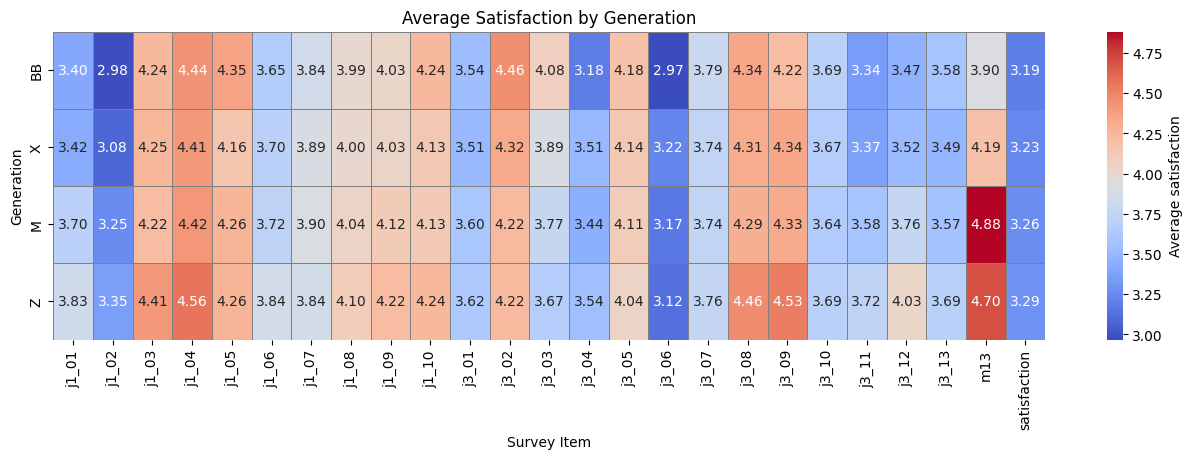

In [587]:
plt.figure(figsize=(16, 4))

sns.heatmap(
    avg_satisfaction_by_generation_clean,      
    annot=True,                          
    fmt=".2f",                           
    cmap="coolwarm",                     
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Average satisfaction'}
)

plt.title("Average Satisfaction by Generation")
plt.xlabel("Survey Item")
plt.ylabel("Generation")
plt.show()

### Generational Patterns in Satisfaction

Gen Z tends to report the highest satisfaction across most aspects, while Baby Boomers generally show the lowest.  
It’s hard to tell whether this difference comes from age itself or from generational attitudes.

**Variables with the lowest average satisfaction**
- **j3_06** - Feeling that tasks are too easy for one’s skillset.  
- **j1_02** - Opportunities for promotion.  
- **Overall job satisfaction.**


**Variables with the highest average satisfaction**
- **m13** - Ability to make ends meet with household income.  
- **j1_04** - Relations with coworkers.  
- **j3_09** - Lack of workplace harassment.

Millennials report finding it easiest to make ends meet among all generations.


**Notable cross-generational patterns**
- For many variables, **Gen X scores slightly lower** than both Baby Boomers and Millennials - e.g.:
  - **Job stability (j1_05)**
  - **Ability to spend enough time with loved ones (j3_13)**


- Reverse trend for **j3_04** (learning new things at work):  
  Gen X is *more satisfied* with opportunities to learn, and also feels *less underchallenged* by simple tasks (**j3_06**) than other generations.


- **Reverse satisfaction trends** (Baby Boomers most satisfied, younger generations less):  
  - Job stability (**j1_05**)  
  - Feeling work has meaning (**j3_02**)  
  - Lack of willingness to change jobs (**j3_03**)  
  - Utilizing knowledge and skills (**j3_05**)
  

**Largest intergenerational differences**
- **m13** - Ease of making ends meet: big leap between Millennials (highest) and Gen X, and another between Gen X and Baby Boomers.  
- **j3_06** - Tasks too easy for skillset: Baby Boomers feel their skills are most underutilized.  
- **j1_02** - Opportunities for promotion: Baby Boomers feel most “stuck.”  
- **j3_04** - Needing to learn new things at work: increase from Baby Boomers to Gen X.  
- **j3_12** - Work’s negative health impact: strong increases between Gen X → Millennials → Gen Z.  
- **j3_09** - Workplace harassment: Gen Z reports the least, notably less than Millennials.

Exporting data

In [ ]:
#survey_selected_df.to_excel('survey_selected.xlsx', index=False)

In [ ]:
#cluster_profiles.to_excel('shap_cluster_profiles.xlsx', index=True)